<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwbf-notebooks/blob/main/4_GSLB_merge_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Load ML model BFD results

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
import time

def load_streamflow_data(data_folder):
    """
    Load all CSV files from the specified folder, parsing 'Date' column as datetime

    Parameters:
    data_folder: Path to the folder containing streamflow CSV files

    Returns:
    Dictionary: Keys are file names (without .csv), values are DataFrames
    """
    streamflow_data = {}
    csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

    for file_path in csv_files:
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        # Parse 'Date' column as datetime while reading the CSV
        df = pd.read_csv(file_path, parse_dates=['Date'])
        streamflow_data[file_name] = df

    print(f"Loaded {len(streamflow_data)} CSV files: {list(streamflow_data.keys())}")
    return streamflow_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/My Drive/xueyi_research/GSLB_gages/'


Mounted at /content/drive


In [3]:
streamflow_data = load_streamflow_data(data_folder)


Loaded 68 CSV files: ['10141000', '10026500', '10041000', '10134500', '10157500', '10015900', '10092700', '10105900', '10132000', '10106000', '10128500', '10159500', '10167000', '10133650', '10155500', '10129900', '10118000', '10136500', '10020300', '10171000', '10143500', '10132500', '10155000', '10079500', '10104700', '10153100', '10163000', '10155200', '10038000', '10133800', '10131000', '10168000', '10011500', '10130500', '10126000', '10020100', '10172860', '10152000', '10104900', '10039500', '10046500', '10142000', '10125500', '10109000', '10129300', '10172700', '10139300', '10023000', '10109001', '10113500', '10133600', '10016900', '10146000', '10102250', '10150500', '10137500', '10172952', '10140100', '10129500', '10154200', '10153800', '10058600', '10146400', '10015700', '10164500', '10068500', '10156000', '10168500']


In [4]:
type(streamflow_data) # To check the type of the streamflow_data variable itself


dict

# 2.Create pairs

In [6]:
result_df = pd.read_csv('result.csv')
result_df['Date'] = pd.to_datetime(result_df['Date'])  # Convert 'Date' to datetime

In [7]:
def find_pairs(streamflow_data, final_measurements_delta, output_dir='output', float_precision=3):
    """
    Finds pairs of well data and streamflow data based on matching dates and ML_BFD filter.
    Saves individual CSV files for each gage ID.

    Args:
        streamflow_data (dict): Dictionary of streamflow DataFrames.
        final_measurements_delta (pd.DataFrame): DataFrame containing well data with Delta_WTE.
        output_dir (str): Directory to store the output CSV files.

    Returns:
        list: List of created CSV filenames.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    created_files = []  # Keep track of created files

    for gage_id, streamflow_df in streamflow_data.items():
        print(f"Working on Gage {gage_id}")
        start = time.time()

        # Filter streamflow data based on ML_BFD
        filtered_streamflow = streamflow_df[streamflow_df['ML_BFD'] == 1][['Date', 'Q']]
        print(f"Filtered Streamflow Data Shape: {filtered_streamflow.shape}")

        # Add gage_id to the filtered streamflow data
        filtered_streamflow['gage_id'] = gage_id

        # Ensure 'Date' column in final_measurements_delta is datetime
        final_measurements_delta['Date'] = pd.to_datetime(final_measurements_delta['Date'])

        # Perform the merge operation
        paired = filtered_streamflow.merge(
            final_measurements_delta[['Well_ID', 'Date', 'Delta_WTE', 'WTE']],
            on='Date',
            how='inner'  # Only keep matches
        )

        # Reorder columns to place 'gage_id' first
        paired = paired[['gage_id'] + [col for col in paired.columns if col != 'gage_id']]

        # Reduce precision of float columns
        float_columns = paired.select_dtypes(include=['float64', 'float32']).columns
        for col in float_columns:
            paired[col] = paired[col].round(float_precision).astype('float32')

        # Write to individual file if pairs were found
        if not paired.empty:
            output_file = os.path.join(output_dir, f'paired_gage_{gage_id}.csv')
            paired.to_csv(output_file, index=False)
            created_files.append(output_file)

        # Clear memory
        del filtered_streamflow
        del paired

        print(f"Finished Gage {gage_id} with {(time.time() - start):.1f} seconds")

    return created_files

In [8]:
created_files = find_pairs(
    streamflow_data=streamflow_data,
    final_measurements_delta=result_df,
    output_dir='paired_data',
    float_precision=3
)

Working on Gage 10141000
Filtered Streamflow Data Shape: (825, 2)
Finished Gage 10141000 with 0.0 seconds
Working on Gage 10026500
Filtered Streamflow Data Shape: (3319, 2)
Finished Gage 10026500 with 0.0 seconds
Working on Gage 10041000
Filtered Streamflow Data Shape: (1533, 2)
Finished Gage 10041000 with 0.0 seconds
Working on Gage 10134500
Filtered Streamflow Data Shape: (11491, 2)
Finished Gage 10134500 with 0.0 seconds
Working on Gage 10157500
Filtered Streamflow Data Shape: (9100, 2)
Finished Gage 10157500 with 0.0 seconds
Working on Gage 10015900
Filtered Streamflow Data Shape: (1948, 2)
Finished Gage 10015900 with 0.0 seconds
Working on Gage 10092700
Filtered Streamflow Data Shape: (5811, 2)
Finished Gage 10092700 with 0.0 seconds
Working on Gage 10105900
Filtered Streamflow Data Shape: (8304, 2)
Finished Gage 10105900 with 0.0 seconds
Working on Gage 10132000
Filtered Streamflow Data Shape: (7076, 2)
Finished Gage 10132000 with 0.0 seconds
Working on Gage 10106000
Filtered Str

# 3.Plot

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats  # Correct import for stats
def analyze_all_gages(input_dir='paired_data', legend_ncol=2):
    """
    Analyze and plot Q-Delta_WTE relationships for all gage files in the directory

    Parameters:
    -----------
    input_dir : str
        Directory containing the paired data files
    legend_ncol : int
        Number of columns in legend

    Returns:
    --------
    DataFrame: Summary statistics for all gages
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats  # Correct import for stats
    import os

    # Get all CSV files in directory
    all_files = [f for f in os.listdir(input_dir) if f.startswith('paired_gage_') and f.endswith('.csv')]
    print(f"Found {len(all_files)} gage files")

    all_stats = []

    for file in all_files:
        gage_id = file.replace('paired_gage_', '').replace('.csv', '')
        print(f"\nProcessing gage {gage_id}")

        try:
            # Read data
            file_path = os.path.join(input_dir, file)
            gage_data = pd.read_csv(file_path)

            if len(gage_data) < 2:
                print(f"Insufficient data for gage {gage_id}")
                continue

            # Create plot and get statistics
            stats = plot_wte_q_relationship(gage_data, legend_ncol=legend_ncol)
            stats['gage_id'] = gage_id
            all_stats.append(stats)

        except Exception as e:
            print(f"Error processing gage {gage_id}: {str(e)}")

    # Create summary DataFrame
    if all_stats:
        stats_df = pd.DataFrame(all_stats)
        print("\nOverall Analysis Results:")
        print(f"Total gages analyzed: {len(stats_df)}")
        print("\nR² statistics:")
        print(stats_df['overall_r2'].describe())
        return stats_df
    else:
        print("No gages were successfully analyzed")
        return None

def plot_wte_q_relationship(gage_data, fig_size=(10, 6), legend_ncol=2):
    """
    Create scatter plot for a single gage's Q-Delta_WTE relationship
    """
    from scipy import stats  # Correct import for stats

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot data for each well with different colors
    unique_wells = gage_data['Well_ID'].unique()
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_wells)))

    # Plot all wells
    for well_id, color in zip(unique_wells, colors):
        well_data = gage_data[gage_data['Well_ID'] == well_id]
        if well_id == unique_wells[0]:
            ax.scatter(well_data['Q'], well_data['Delta_WTE'],
                      color=color, alpha=0.7, s=60,
                      label=f'Wells (n={len(unique_wells)})')
        else:
            ax.scatter(well_data['Q'], well_data['Delta_WTE'],
                      color=color, alpha=0.7, s=60)

    # Calculate regression line if enough data points
    if len(gage_data) >= 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            gage_data['Q'], gage_data['Delta_WTE'])

        x_range = np.array([gage_data['Q'].min(),
                           gage_data['Q'].max()])
        ax.plot(x_range, slope * x_range + intercept,
               'r--', alpha=0.7, linewidth=2,
               label=f'Regression (R² = {r_value**2:.2f})')

        # Add analysis results text box
        stats_text = (f'Analysis Results:\n'
                     f'Number of wells: {len(unique_wells)}\n'
                     f'Number of measurements: {len(gage_data)}\n'
                     f'R²: {r_value**2:.3f}\n'
                     f'Slope: {slope:.3f}\n'
                     f'P-value: {p_value:.3f}')

        plt.text(0.02, 0.98, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        regression_stats = {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    else:
        regression_stats = {
            'slope': None,
            'r_squared': None,
            'p_value': None
        }

    # Customize plot
    plt.title(f'Q-Delta_WTE Relationship for Gage {gage_data["gage_id"].iloc[0]}',
             fontsize=14, pad=20)

    plt.xlabel('Streamflow (m³/s)', fontsize=12)
    plt.ylabel('Delta WTE (m)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add simplified legend
    plt.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    return {
        'n_wells': len(unique_wells),
        'n_measurements': len(gage_data),
        'overall_r2': regression_stats['r_squared'],
        'slope': regression_stats['slope'],
        'p_value': regression_stats['p_value']
    }



Found 67 gage files

Processing gage 10039500


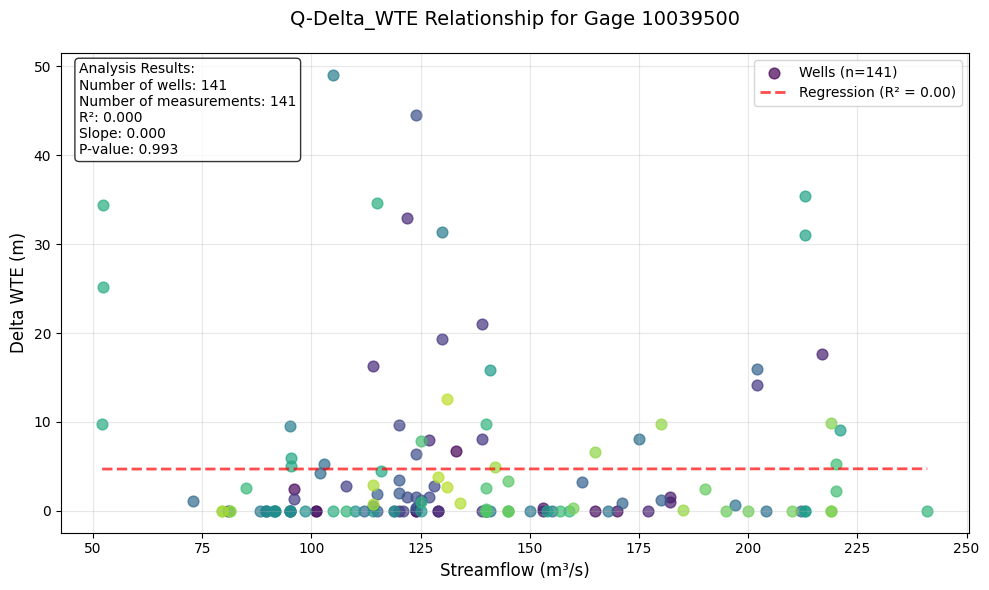


Processing gage 10146400


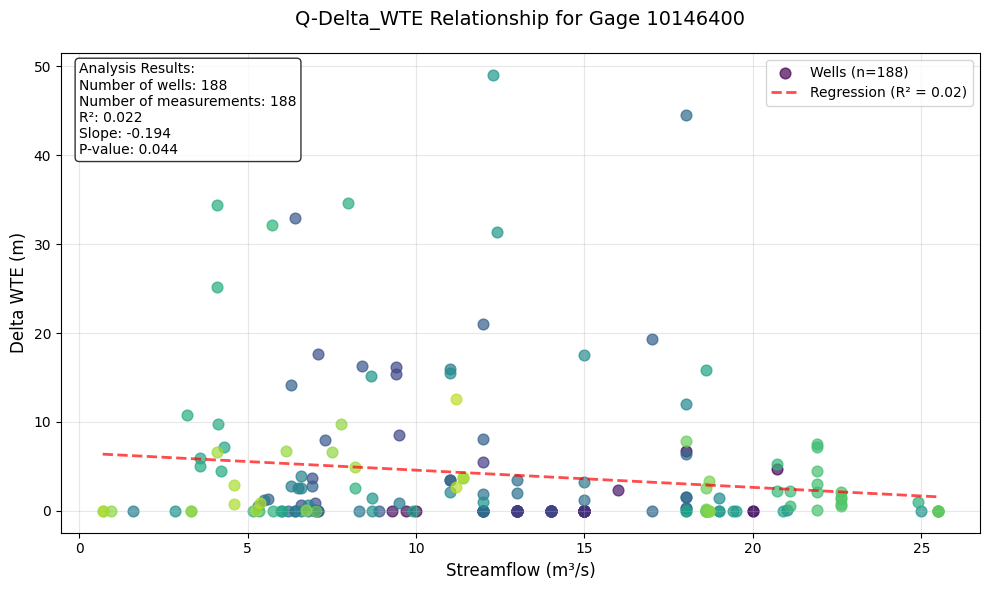


Processing gage 10172860


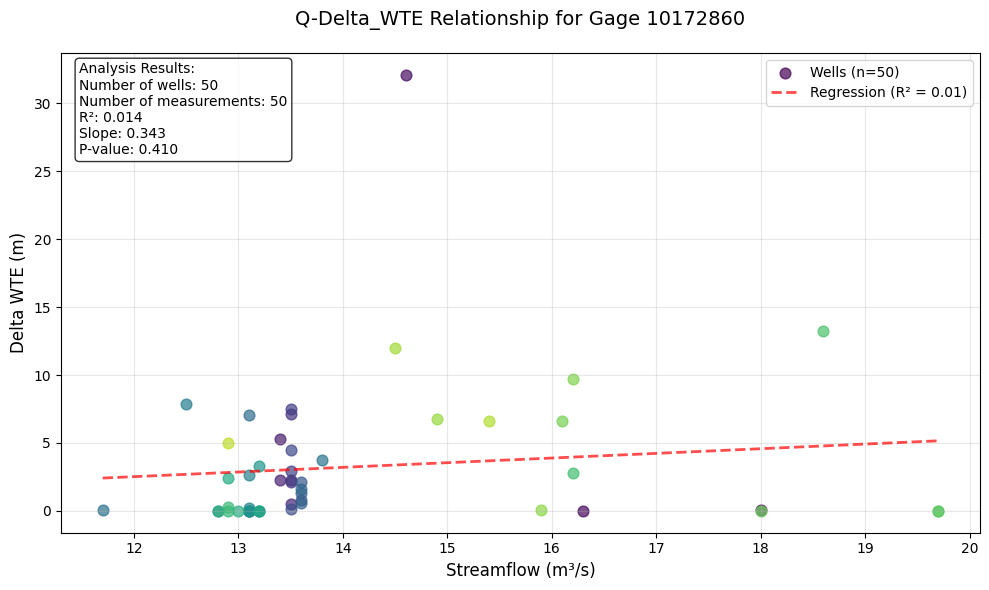


Processing gage 10137500


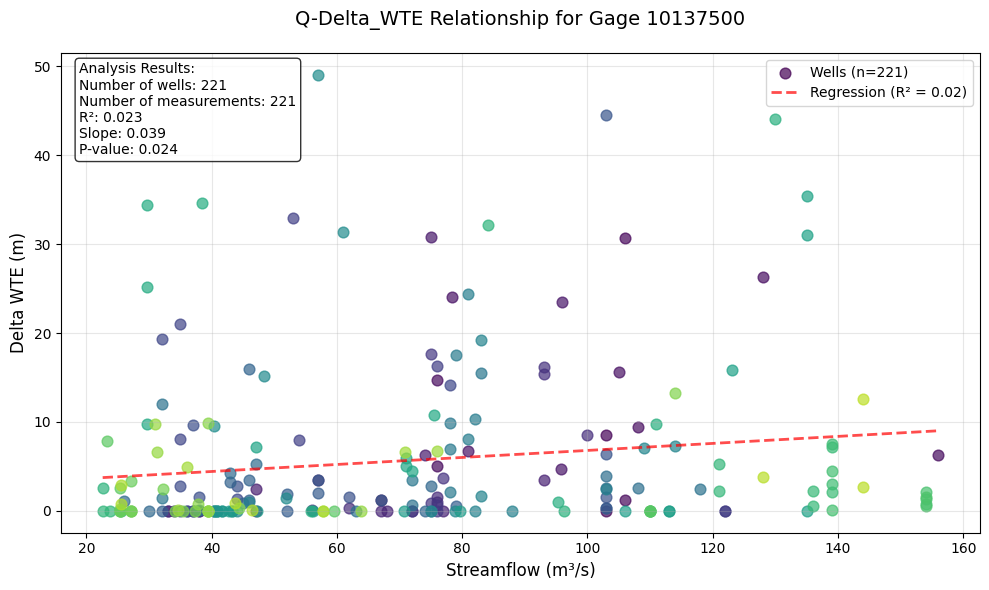


Processing gage 10109000


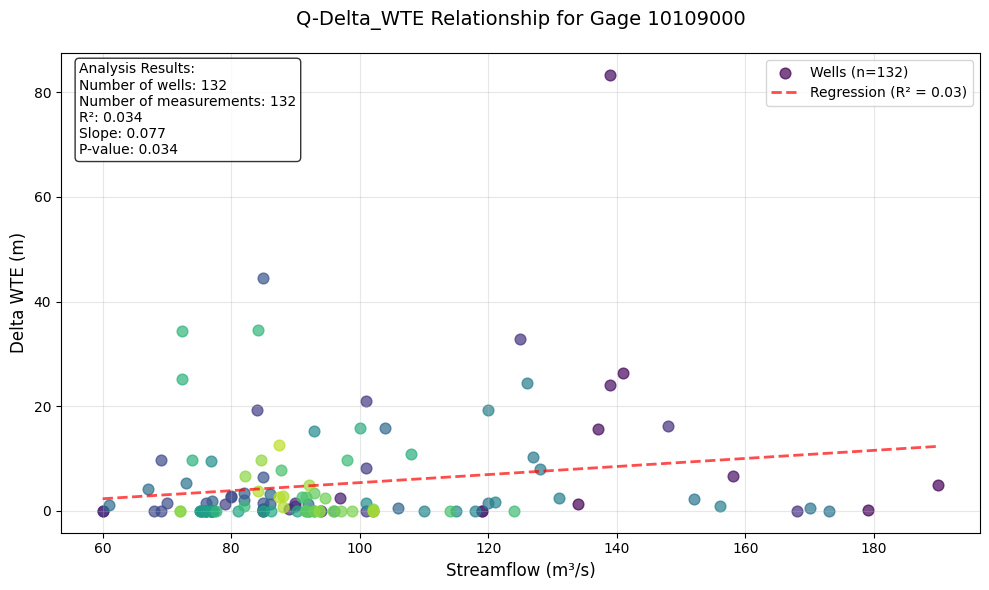


Processing gage 10020300


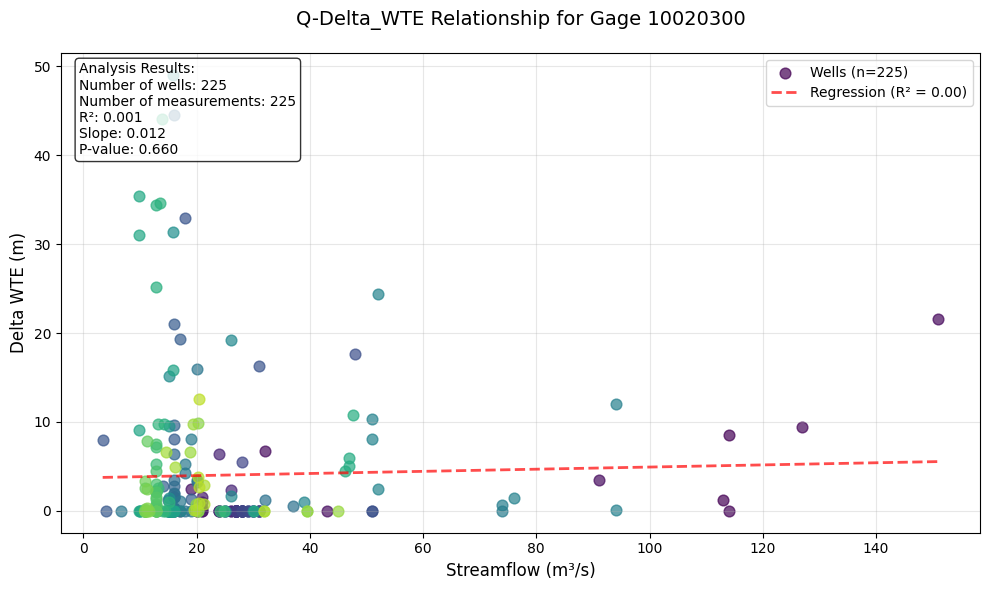


Processing gage 10155500


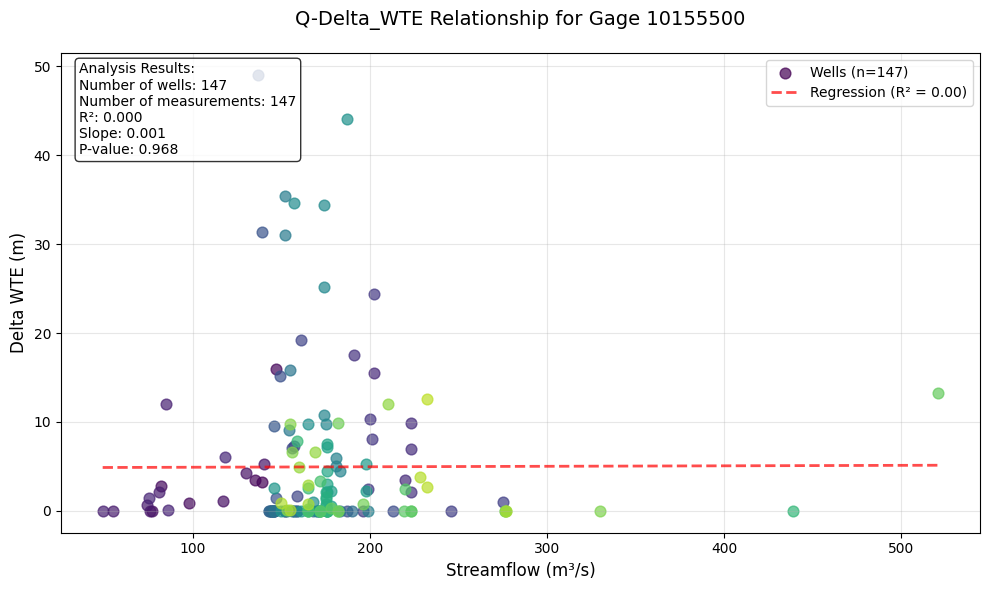


Processing gage 10136500
Error processing gage 10136500: Cannot calculate a linear regression if all x values are identical

Processing gage 10139300


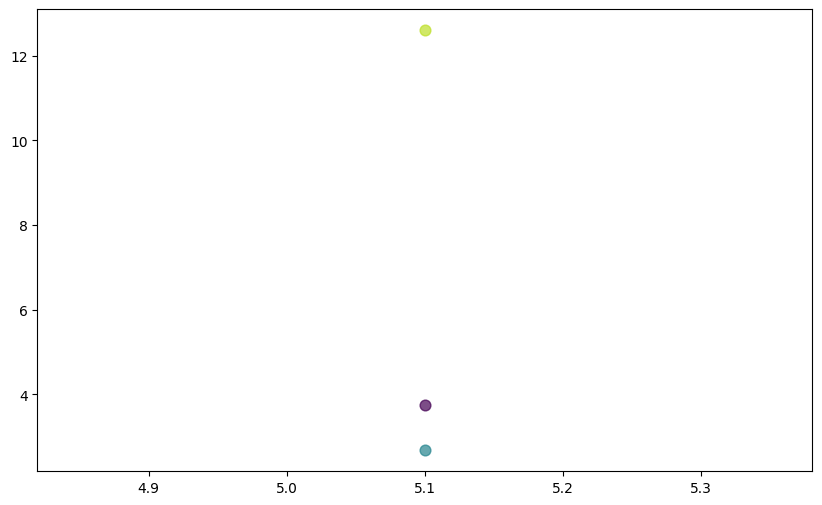

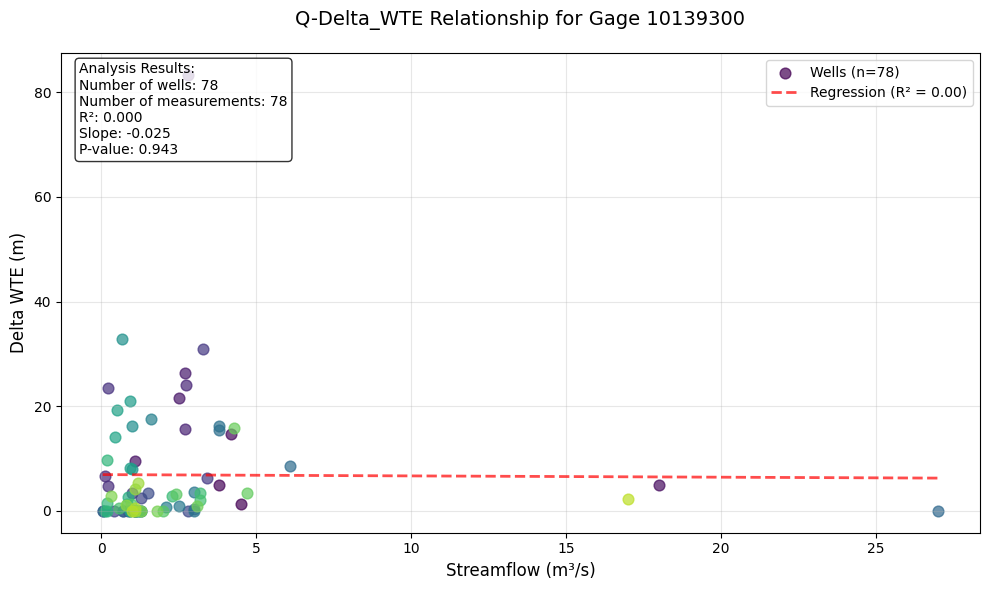


Processing gage 10146000


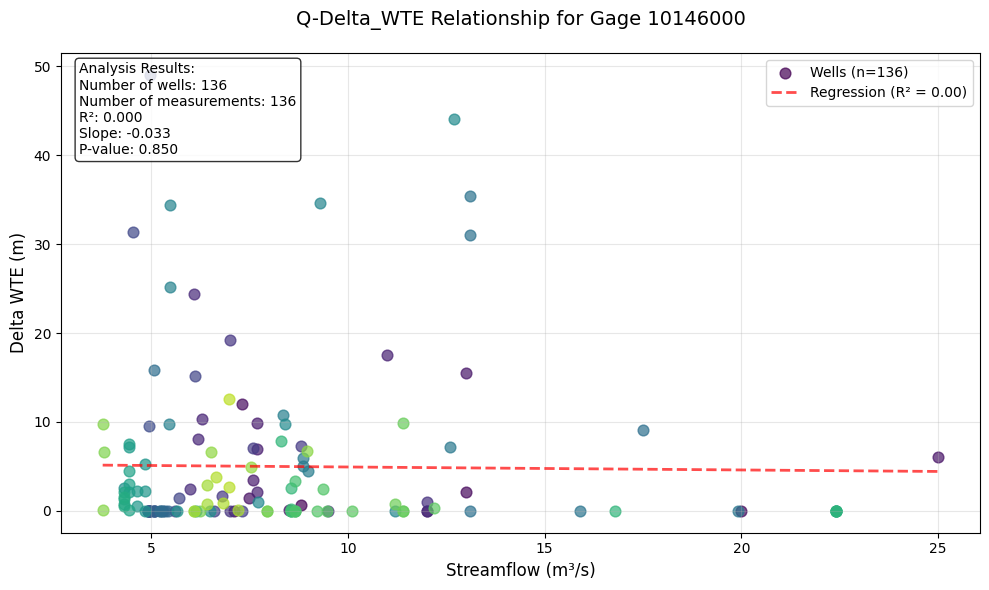


Processing gage 10159500


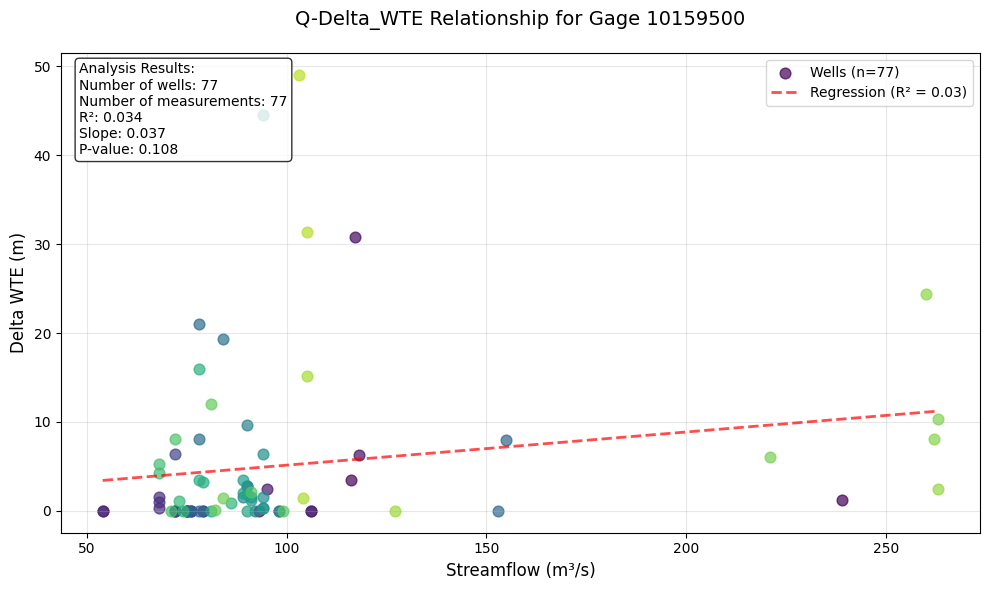


Processing gage 10133600


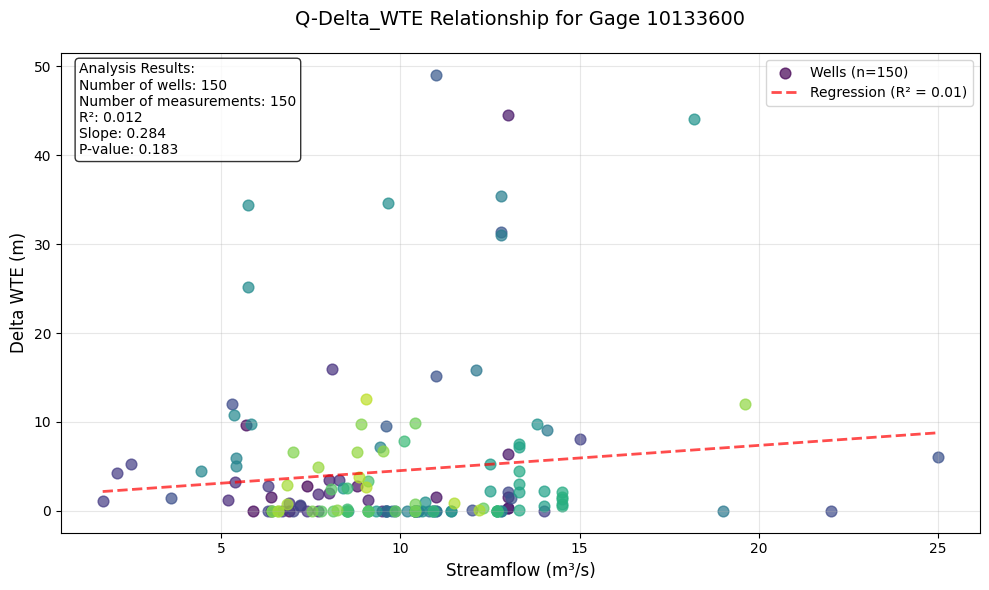


Processing gage 10079500


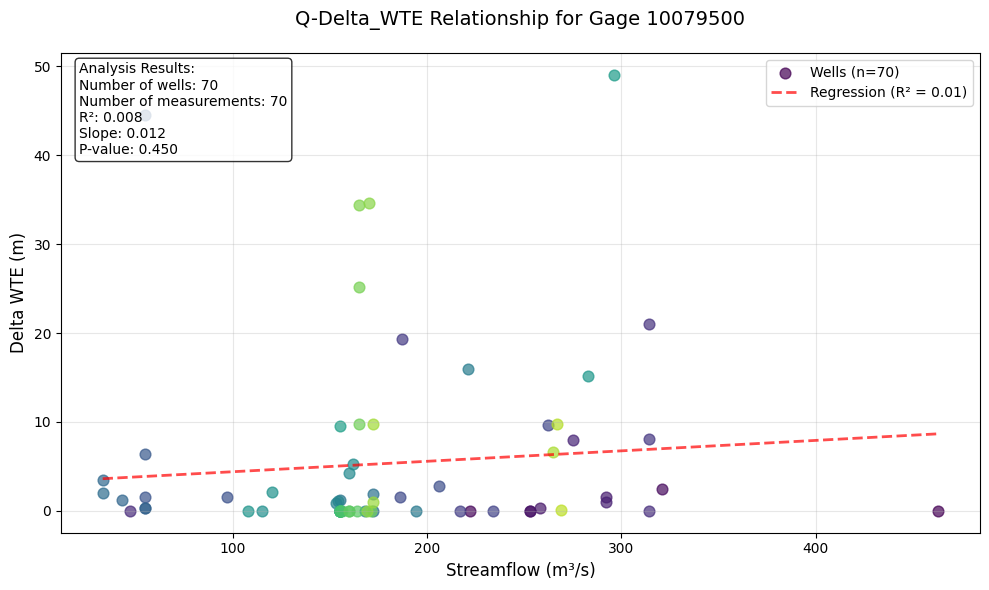


Processing gage 10130500


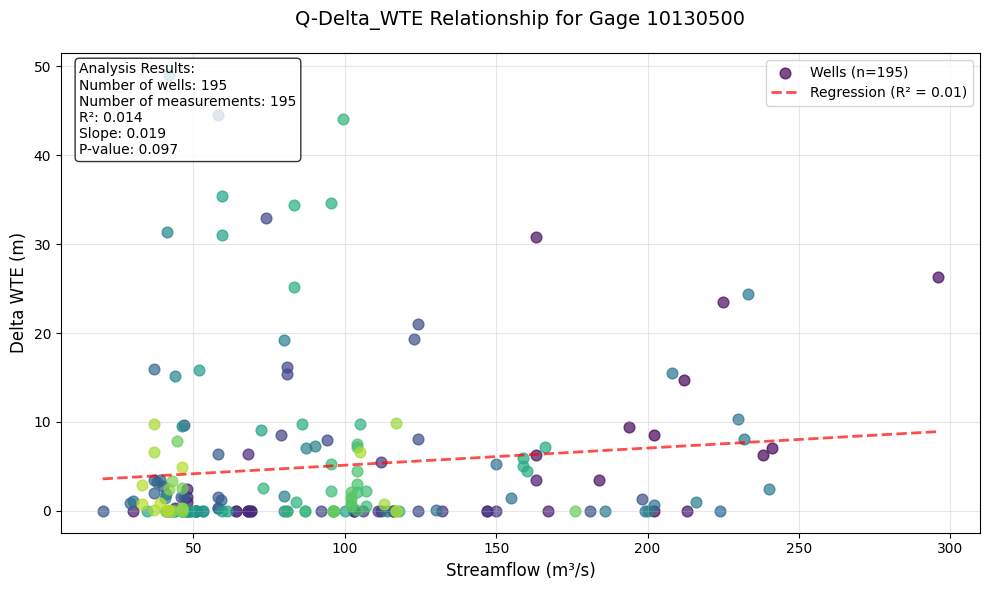


Processing gage 10142000


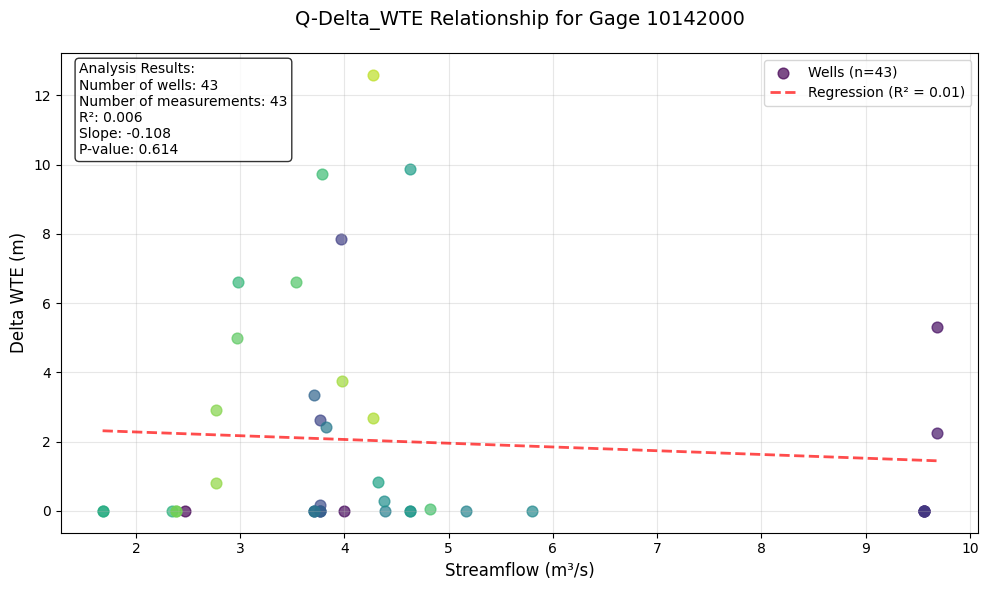


Processing gage 10140100


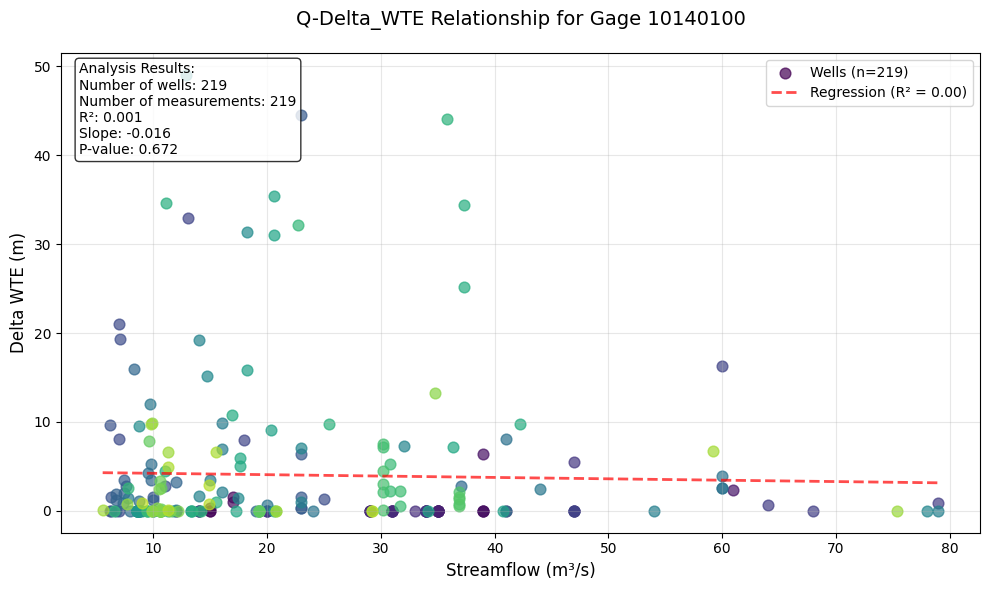


Processing gage 10105900


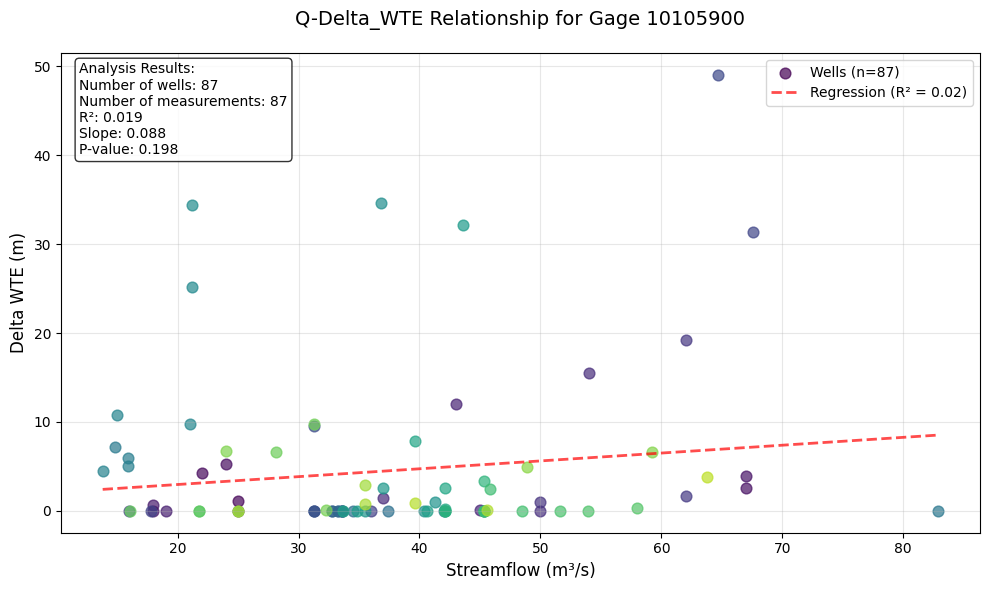


Processing gage 10068500


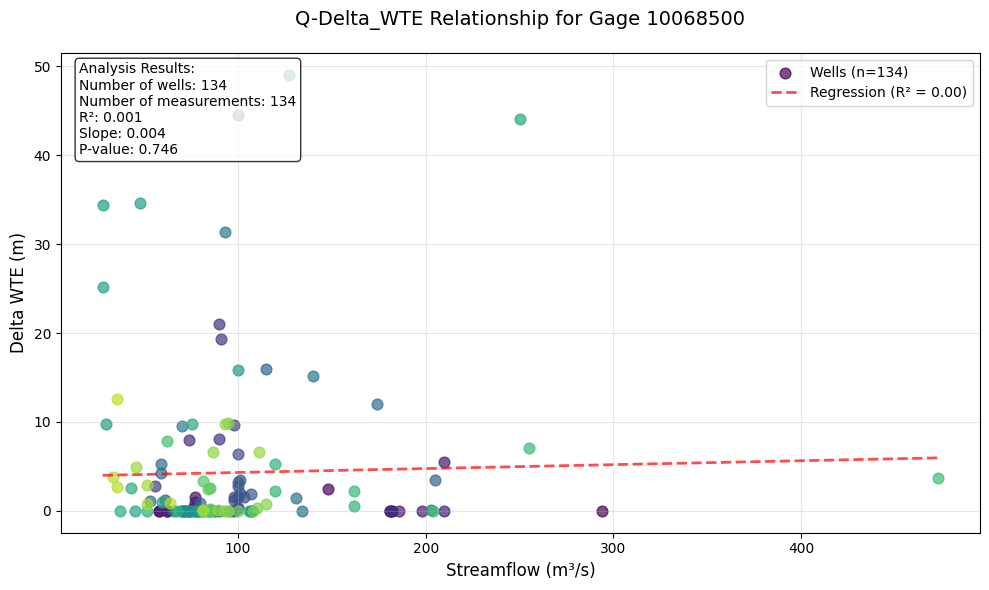


Processing gage 10020100


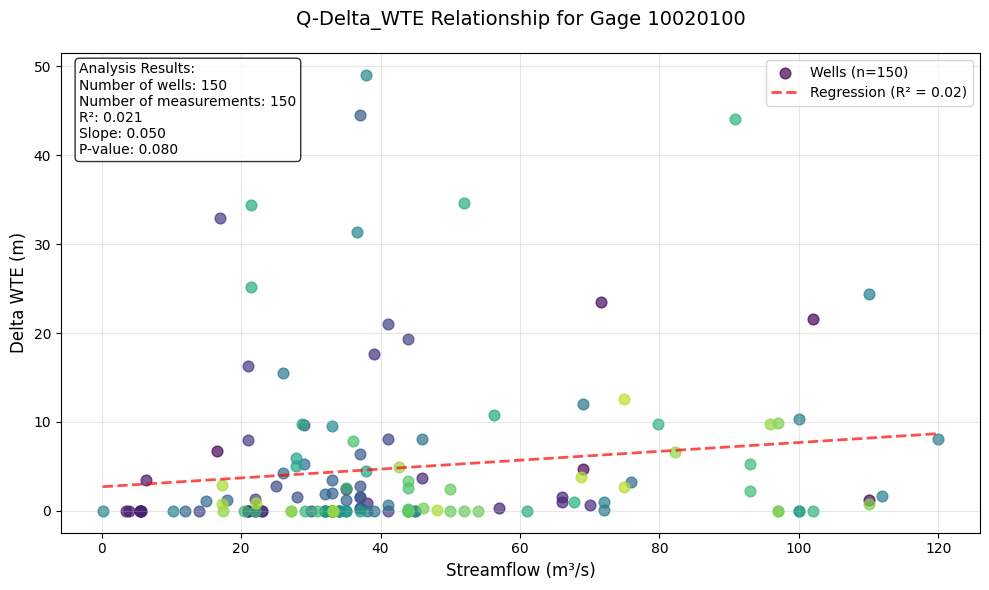


Processing gage 10155200


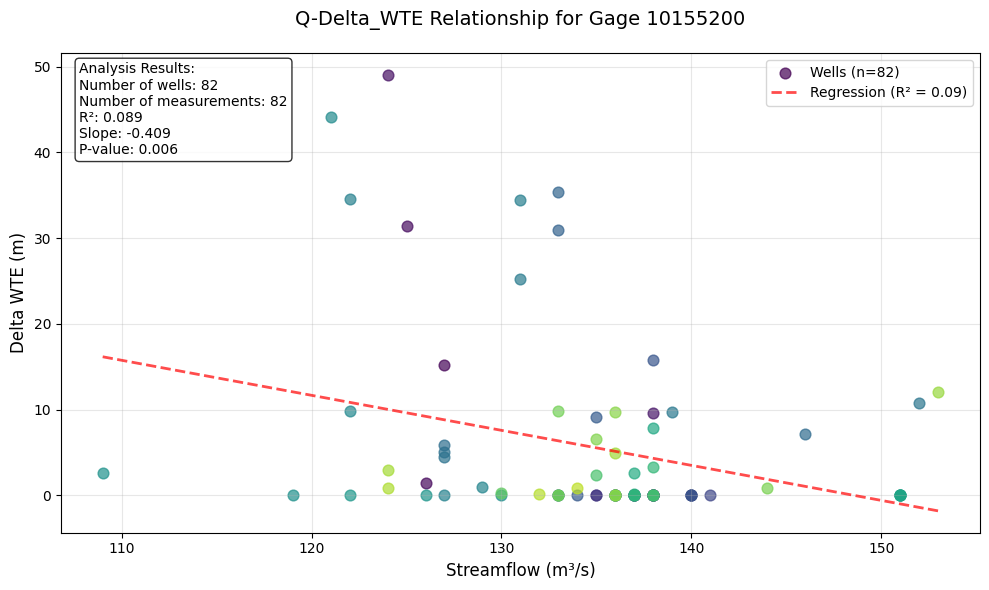


Processing gage 10015700


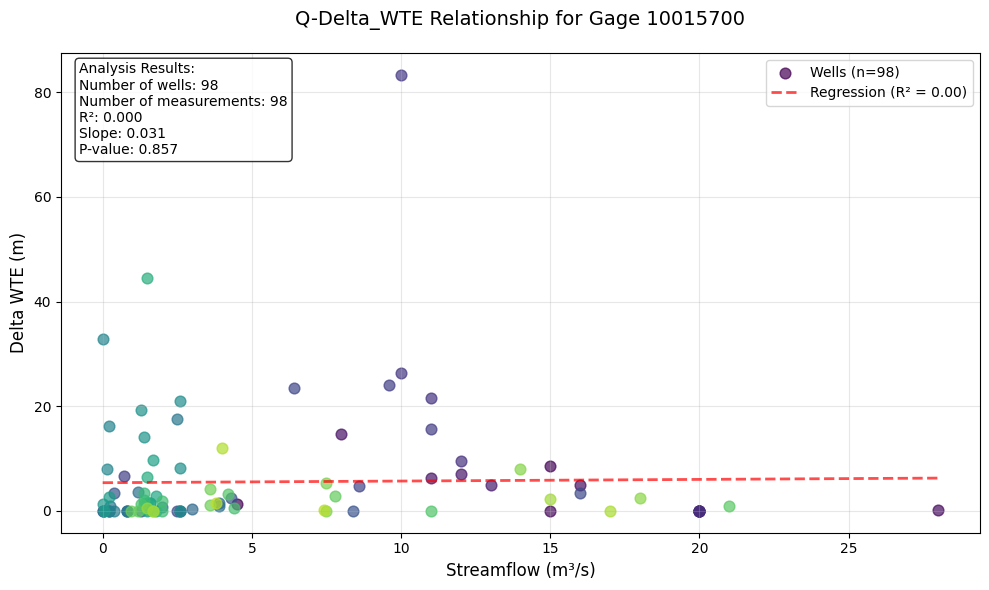


Processing gage 10168500


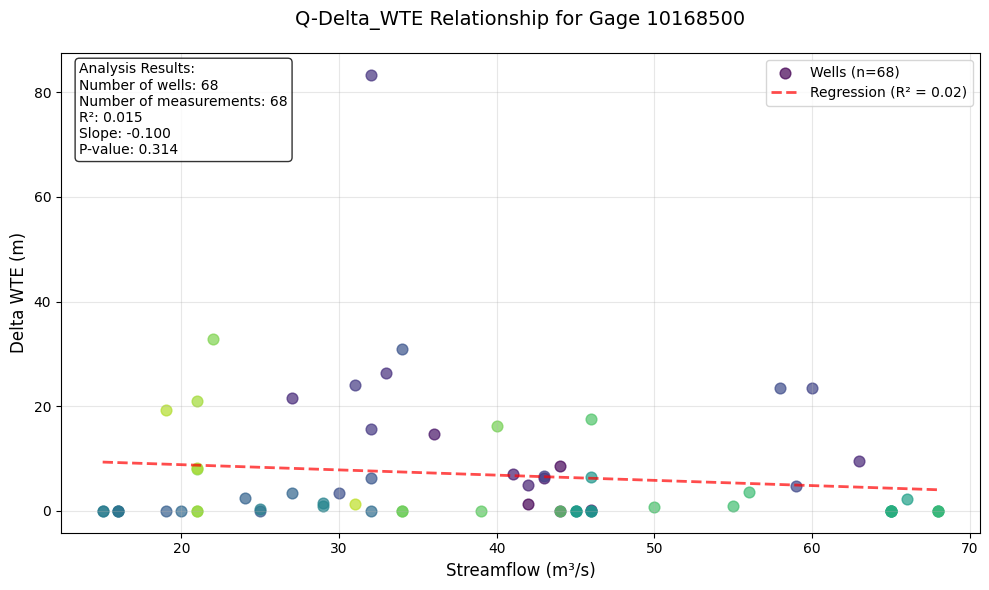


Processing gage 10046500


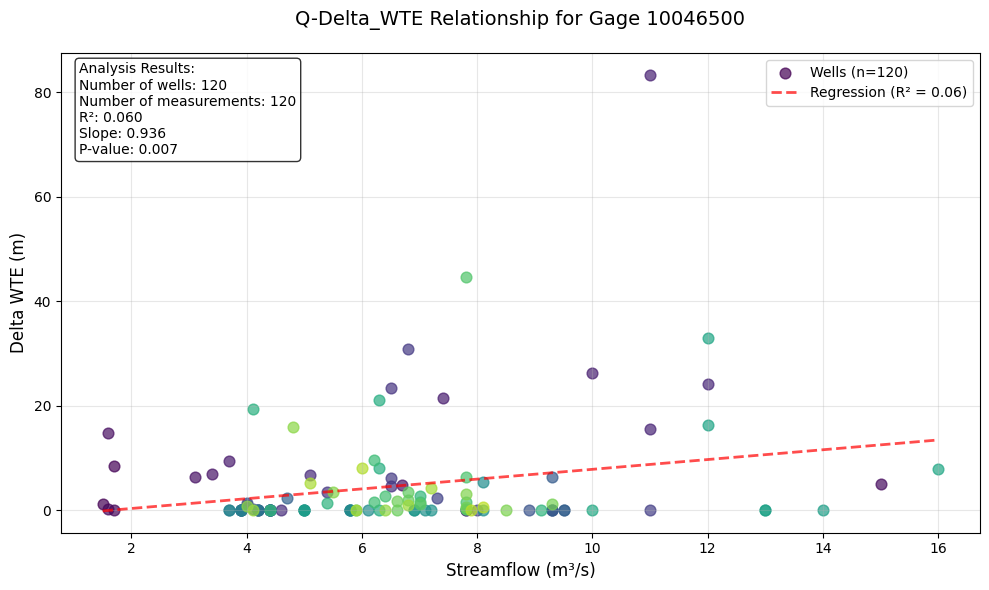


Processing gage 10128500


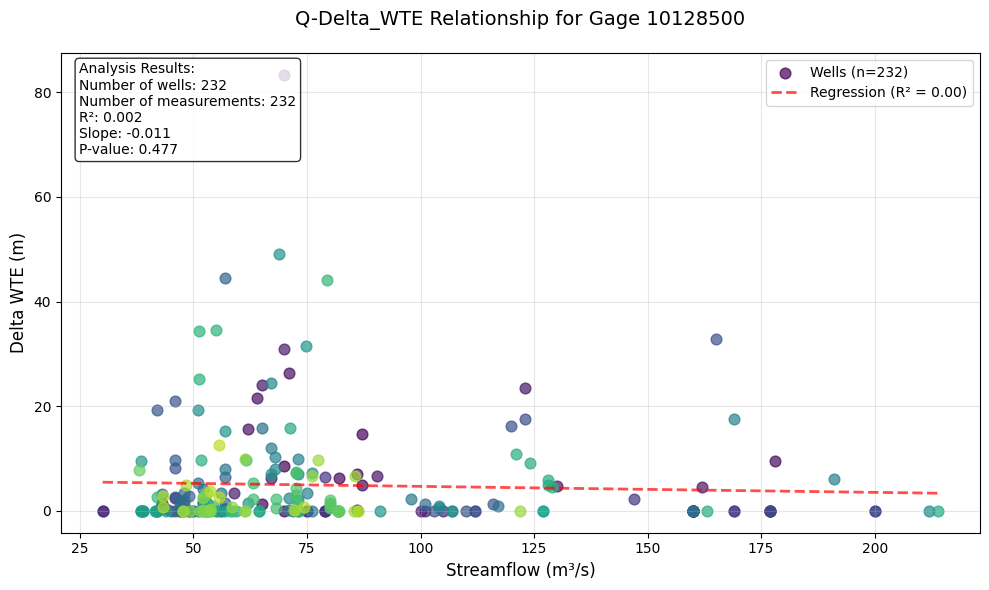


Processing gage 10026500


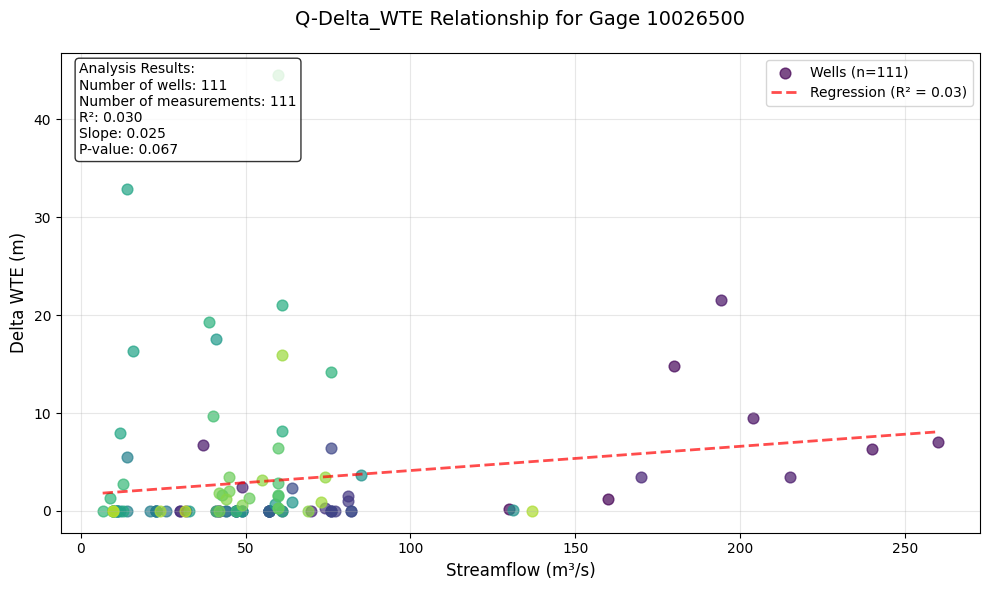


Processing gage 10156000


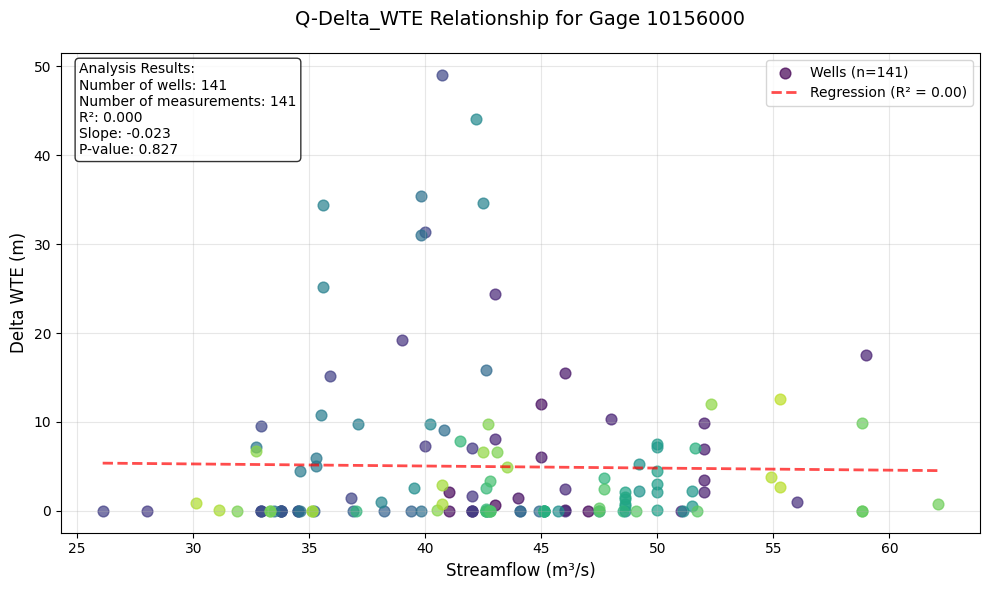


Processing gage 10164500


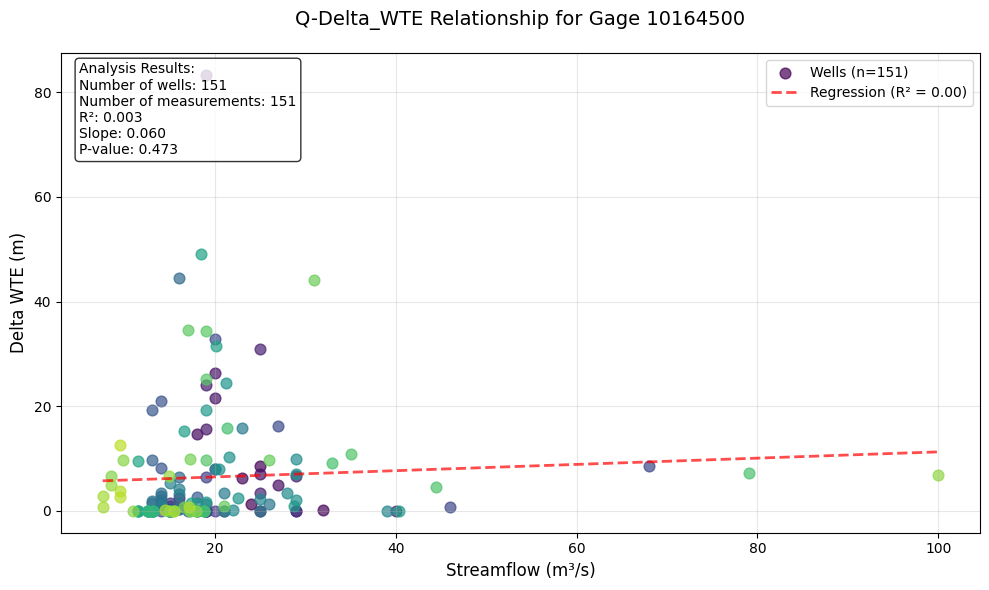


Processing gage 10104900


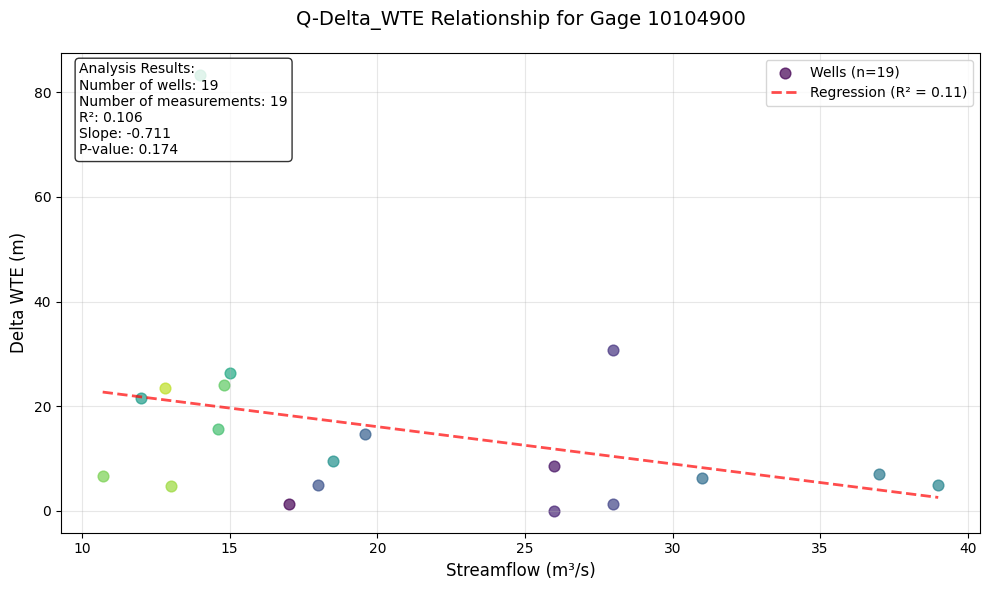


Processing gage 10155000


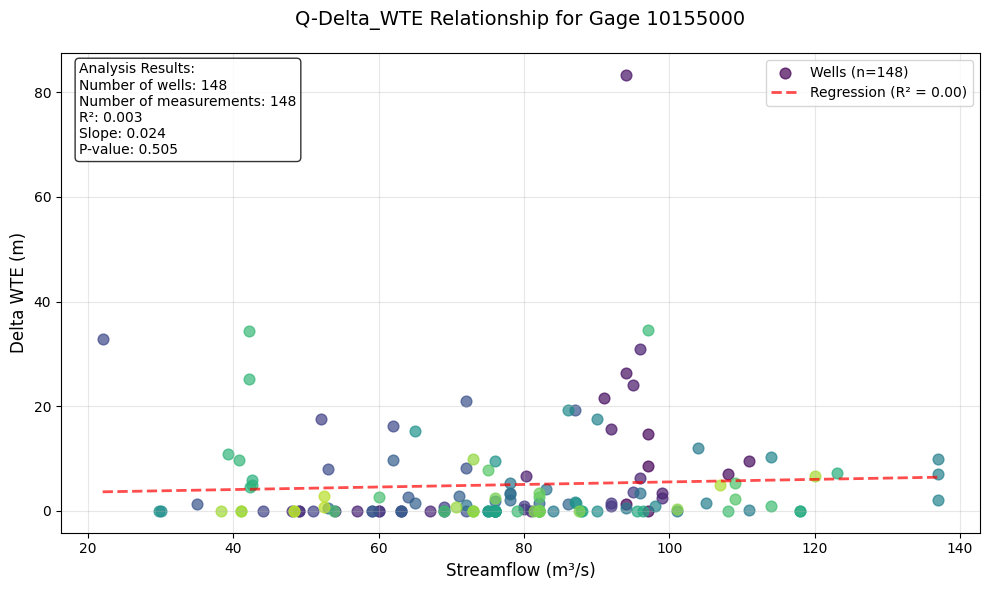


Processing gage 10129500


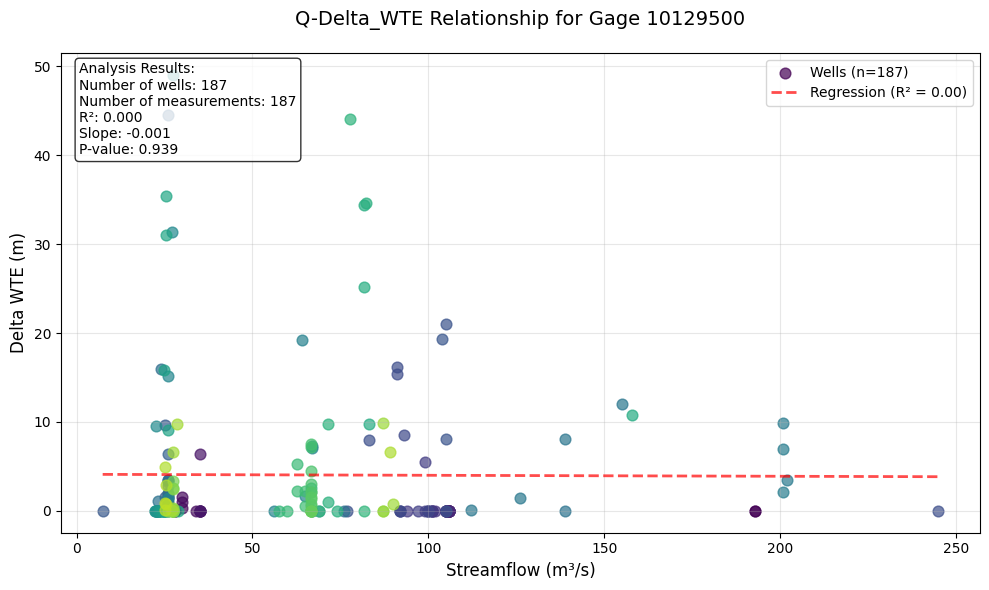


Processing gage 10041000


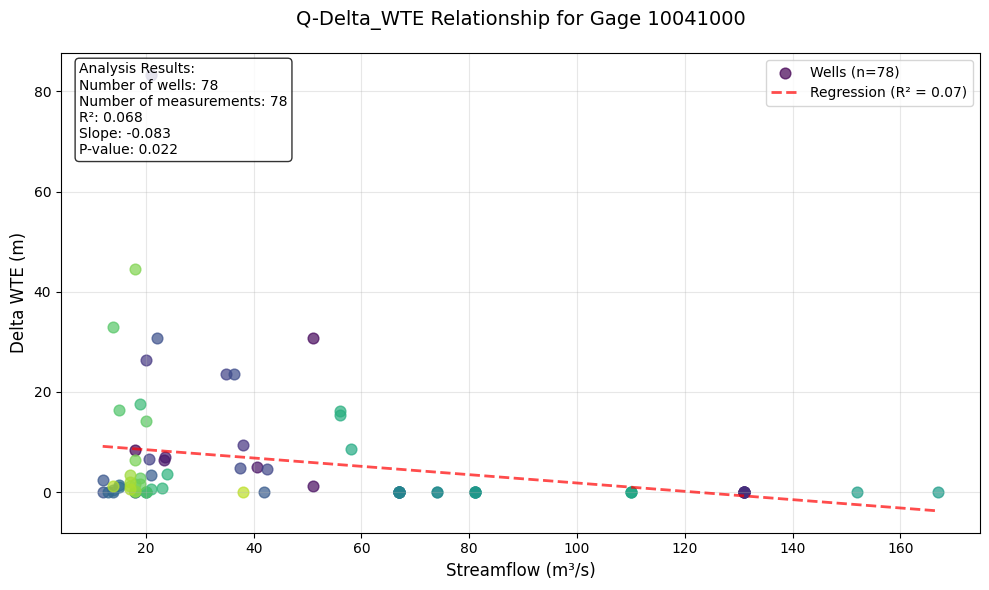


Processing gage 10132000


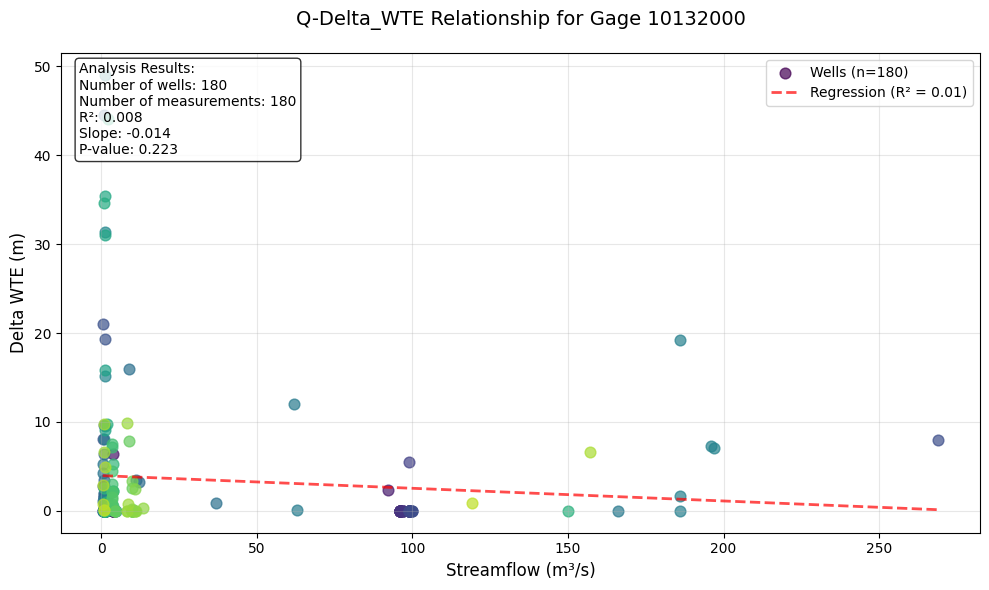


Processing gage 10154200


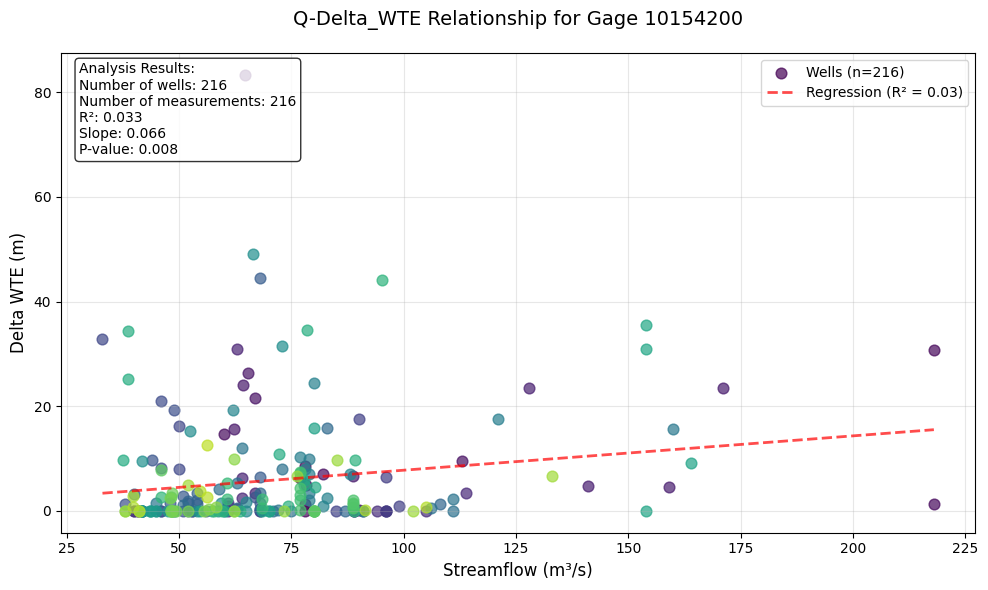


Processing gage 10058600


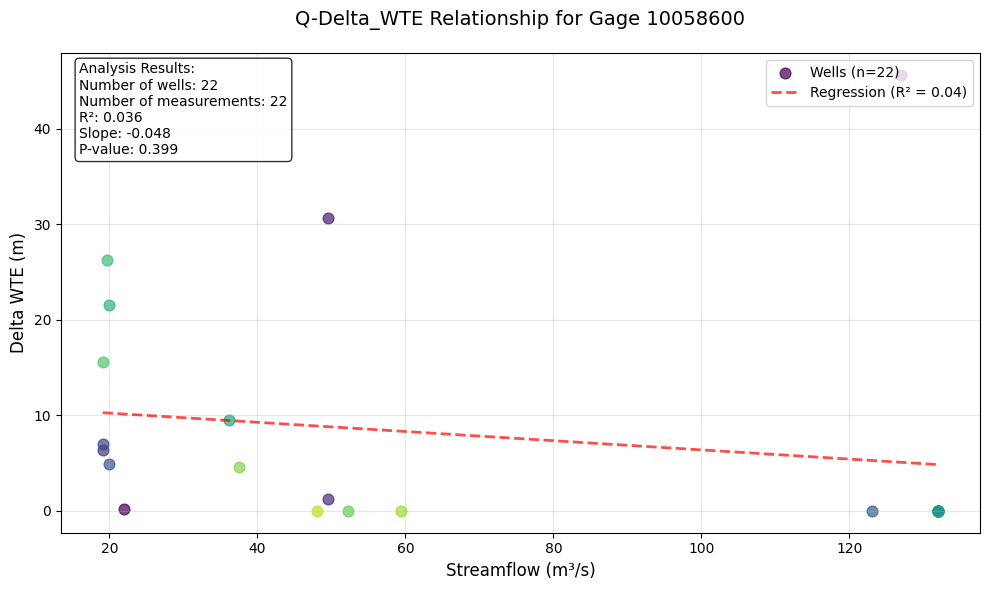


Processing gage 10118000


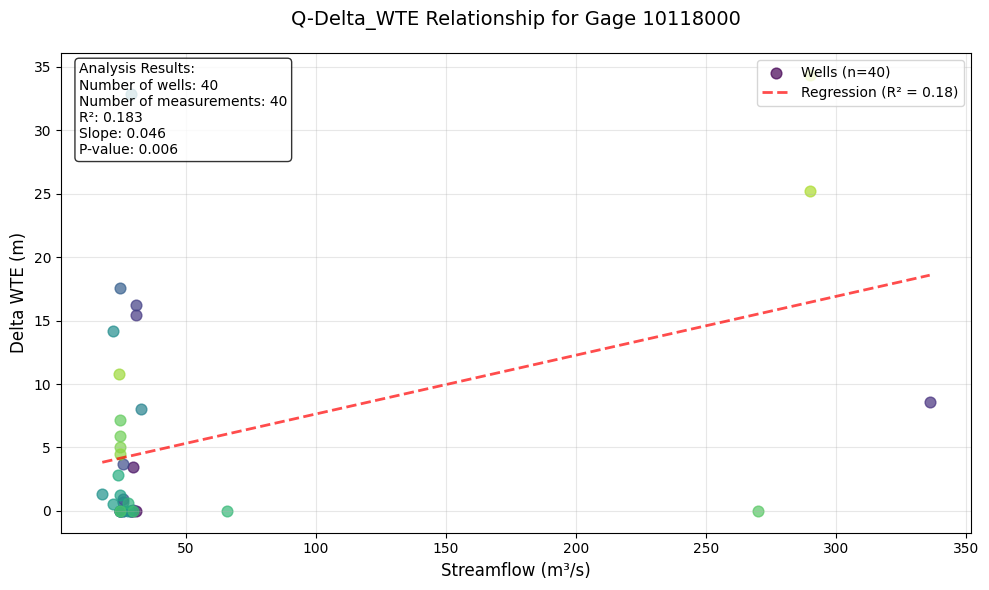


Processing gage 10133650


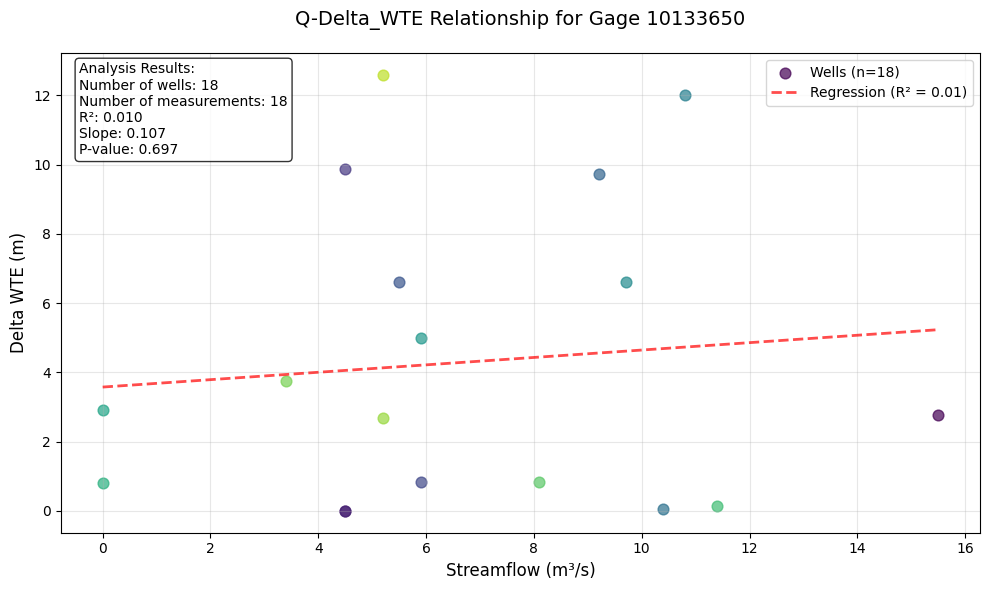


Processing gage 10104700


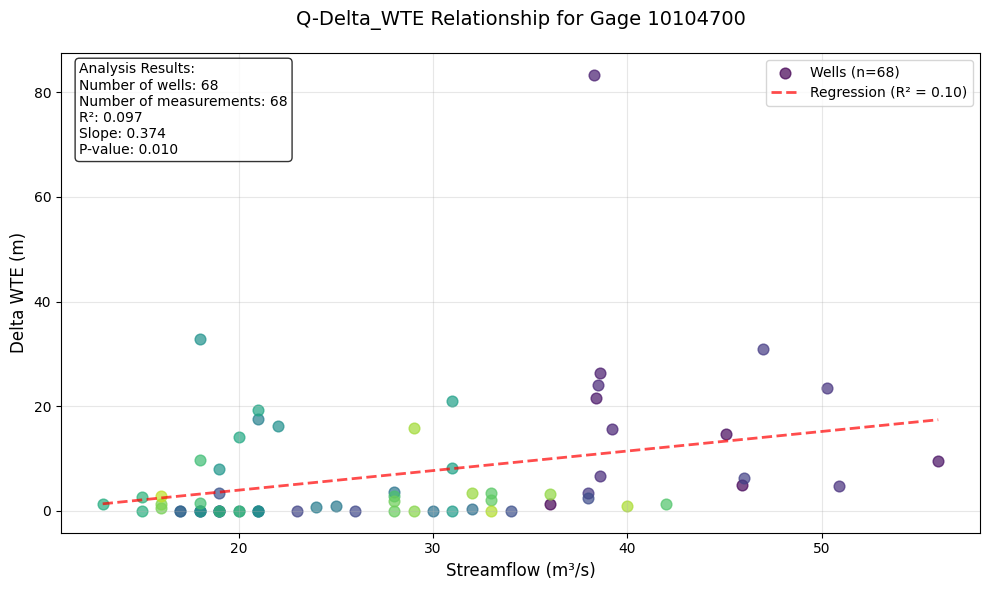


Processing gage 10109001


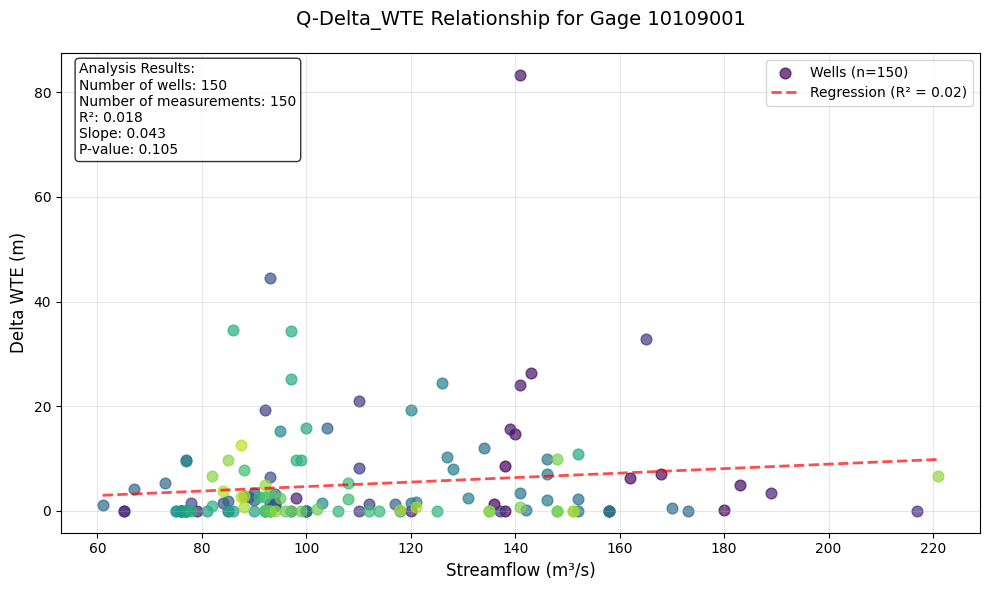


Processing gage 10157500


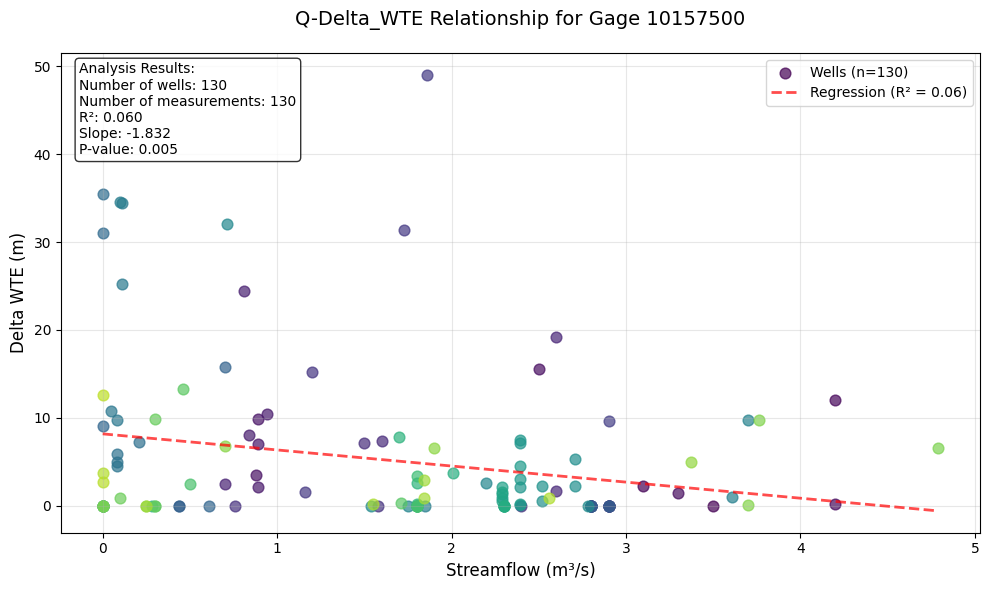


Processing gage 10016900


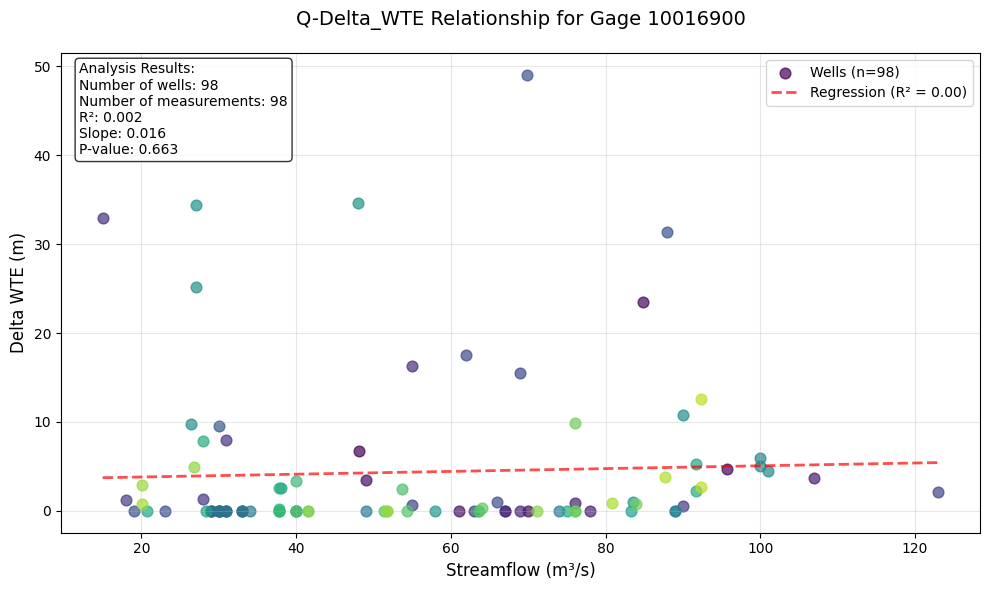


Processing gage 10129900


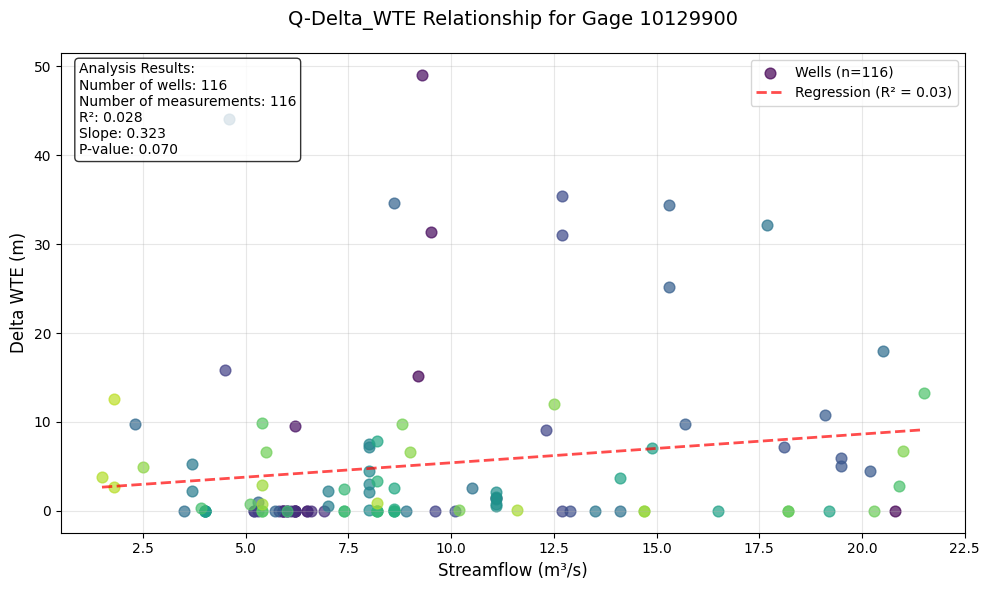


Processing gage 10102250


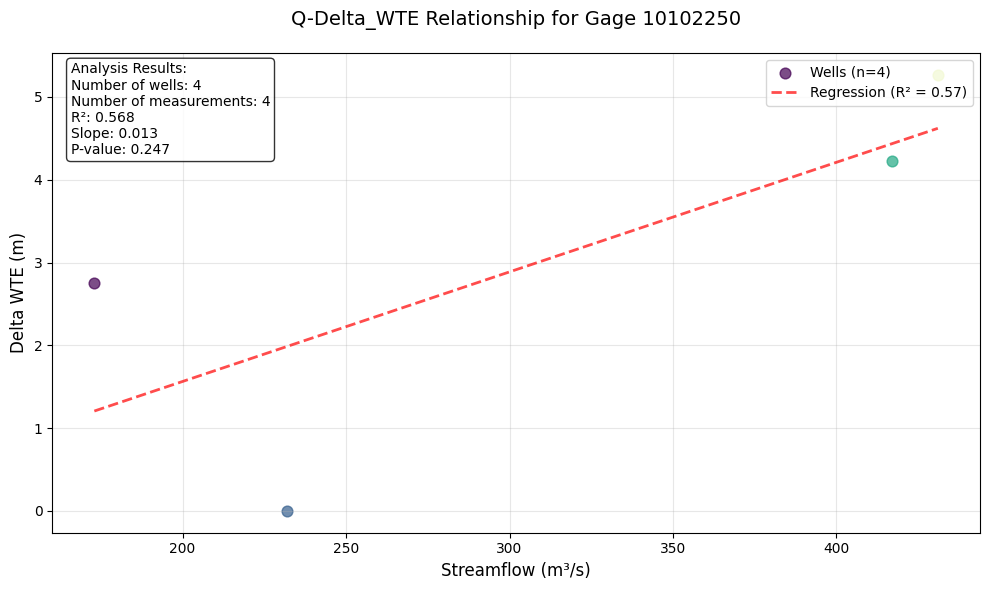


Processing gage 10011500


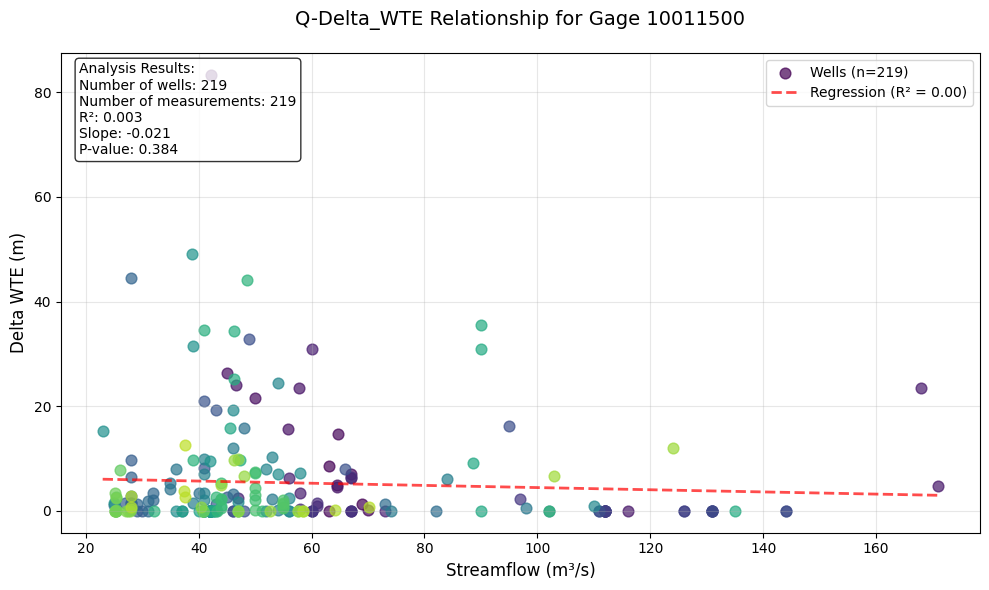


Processing gage 10163000


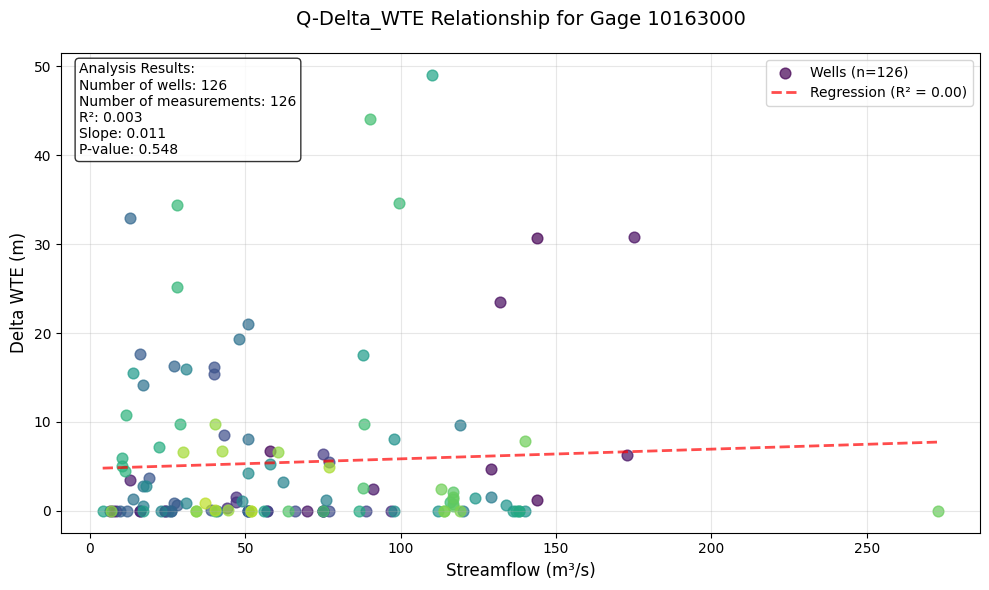


Processing gage 10092700


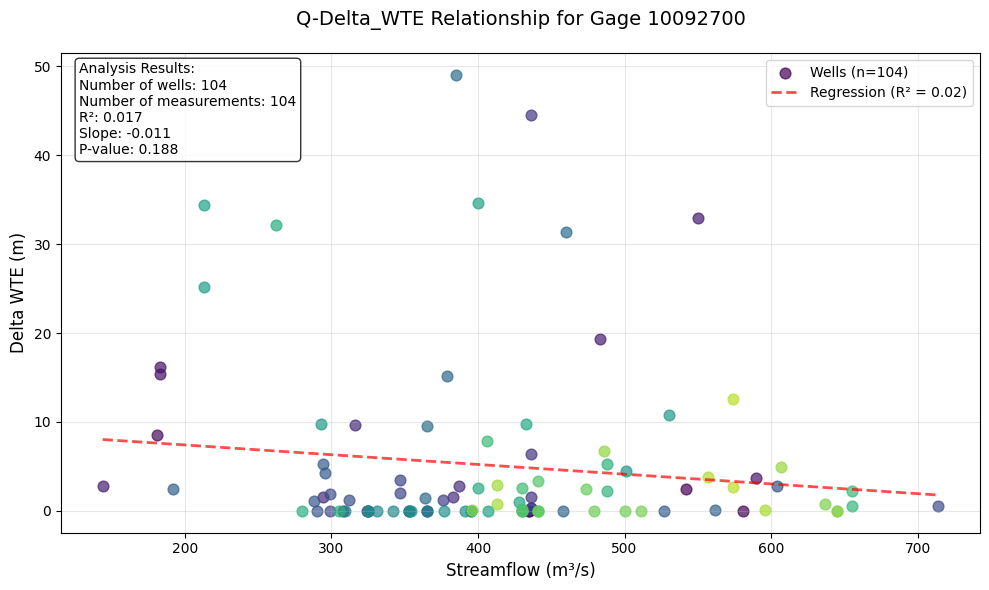


Processing gage 10167000


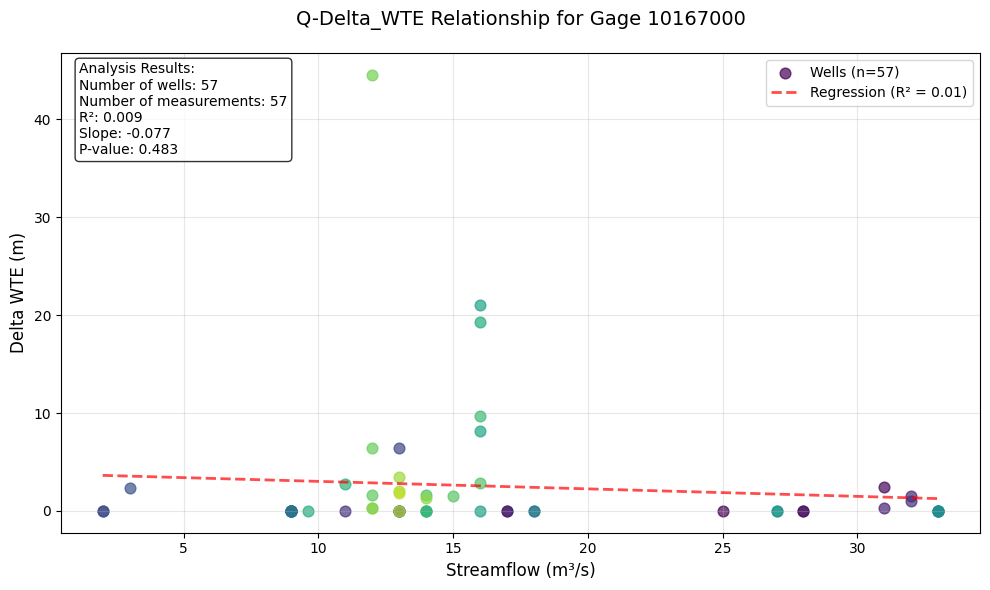


Processing gage 10171000


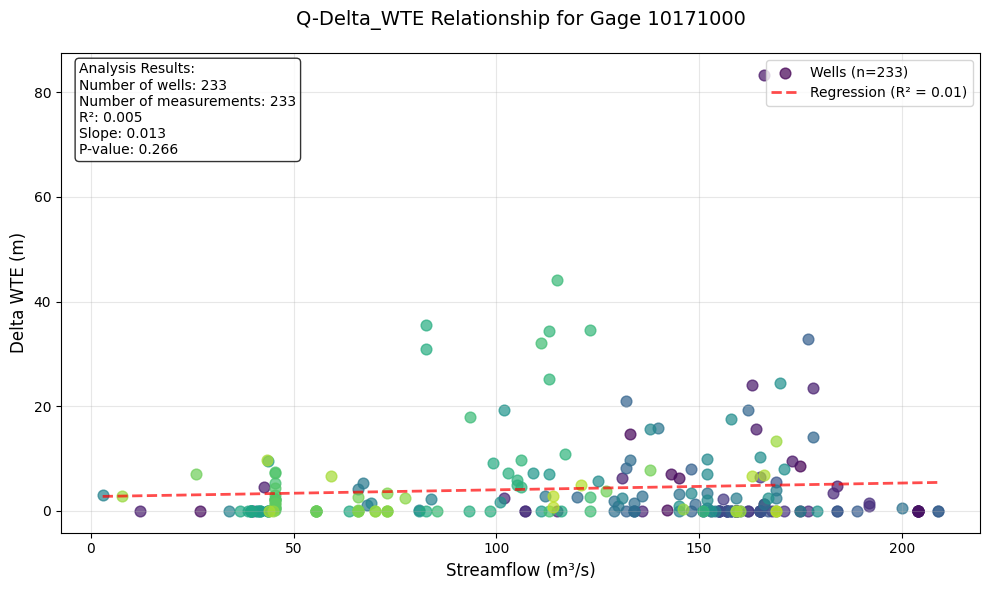


Processing gage 10153100


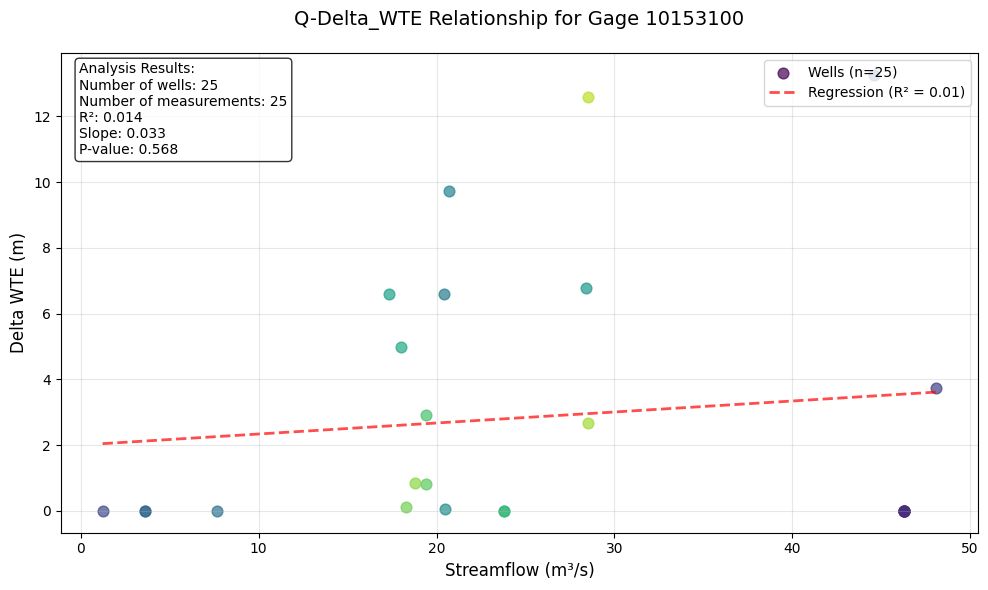


Processing gage 10153800


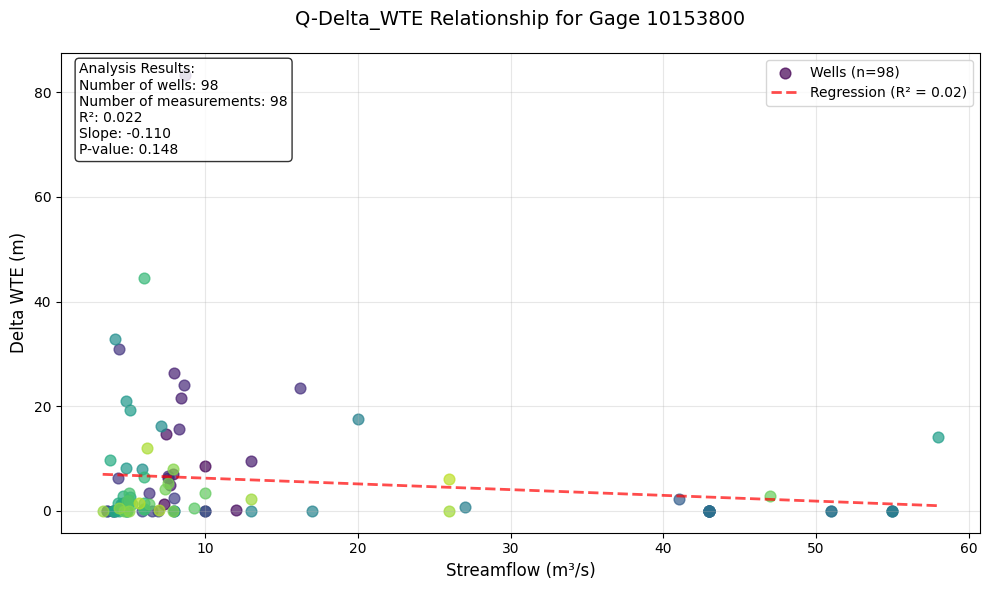


Processing gage 10172952


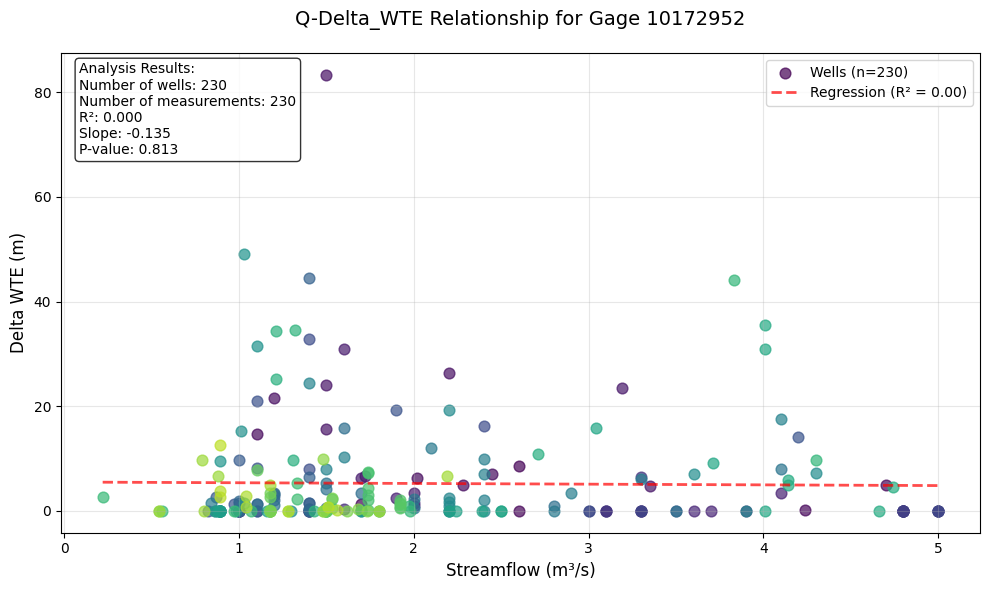


Processing gage 10023000


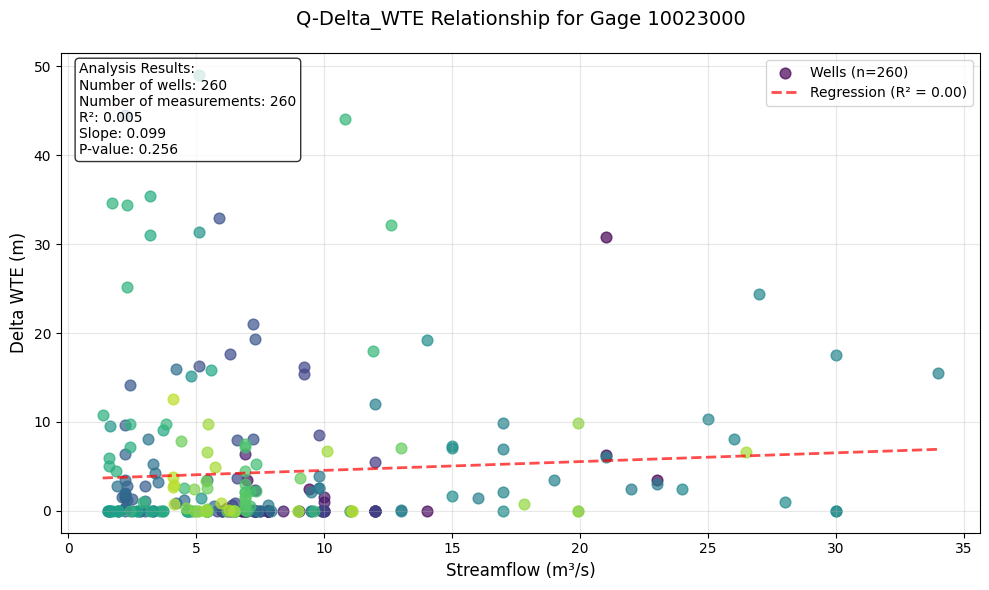


Processing gage 10168000


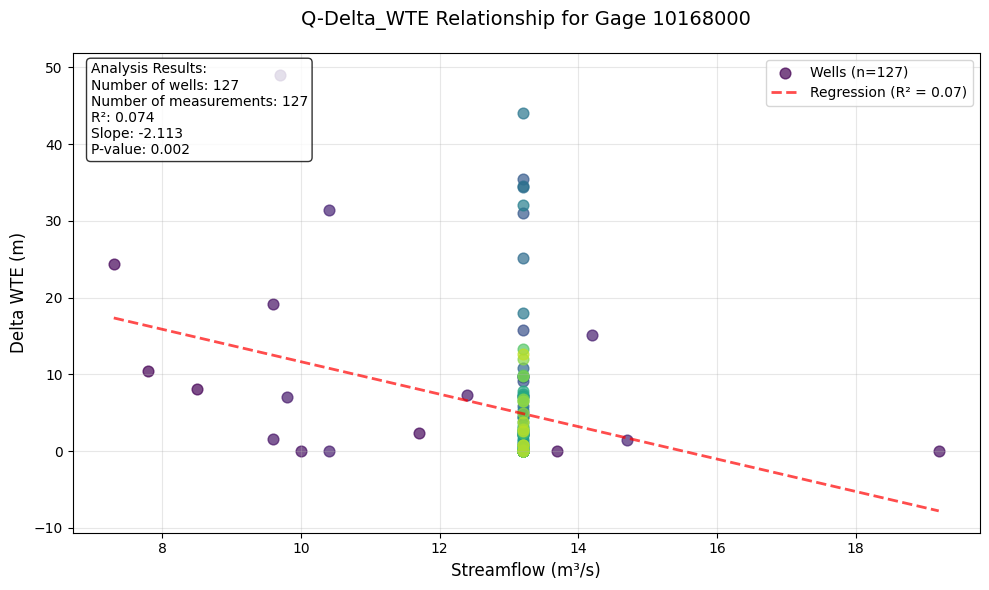


Processing gage 10132500


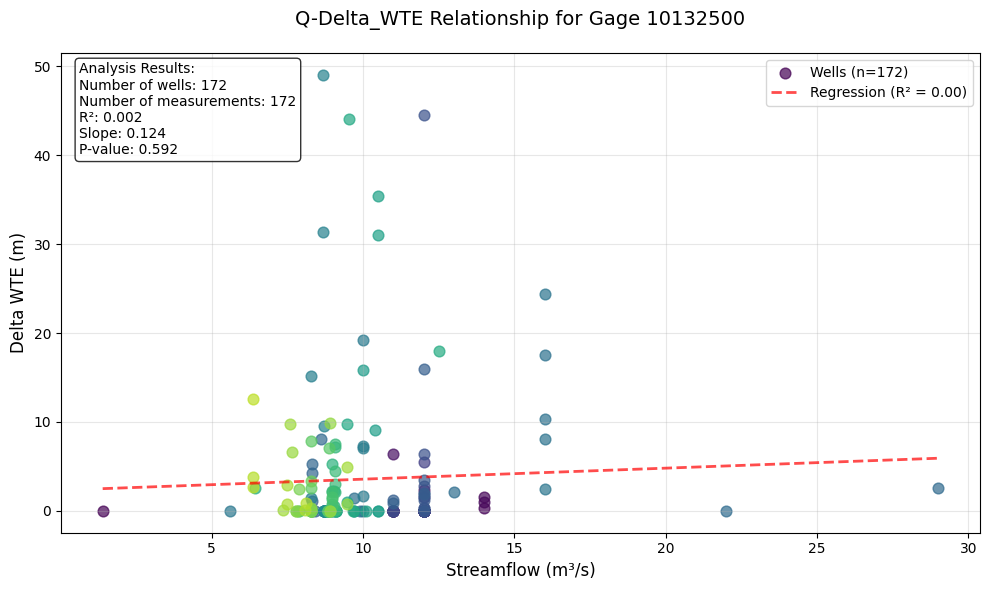


Processing gage 10133800


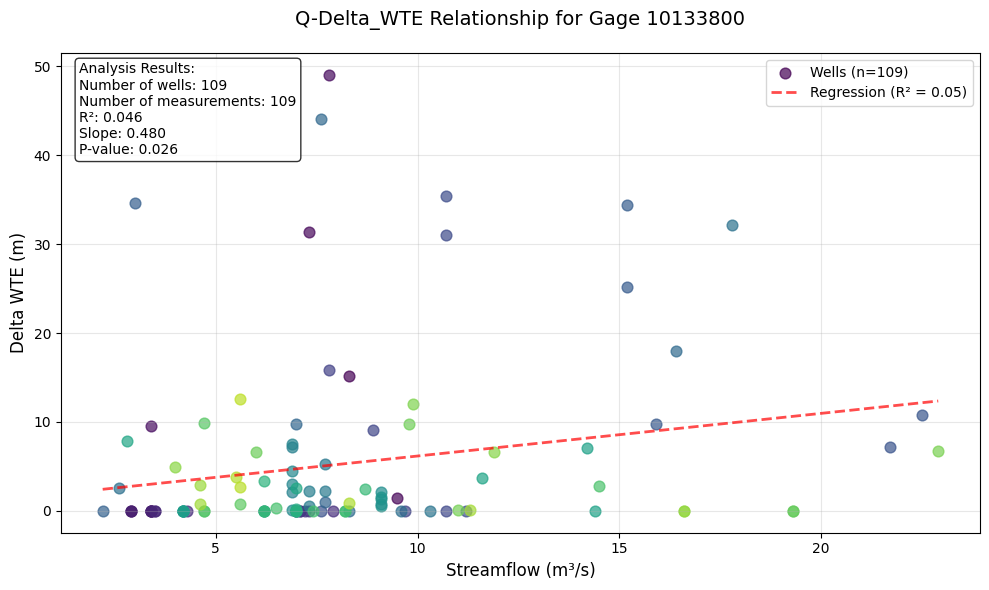


Processing gage 10172700


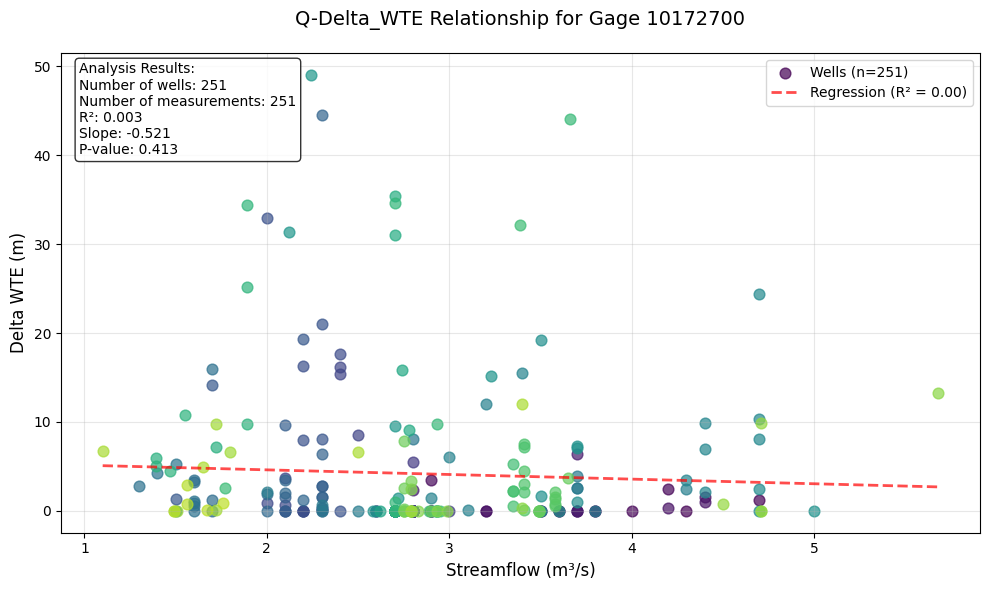


Processing gage 10113500


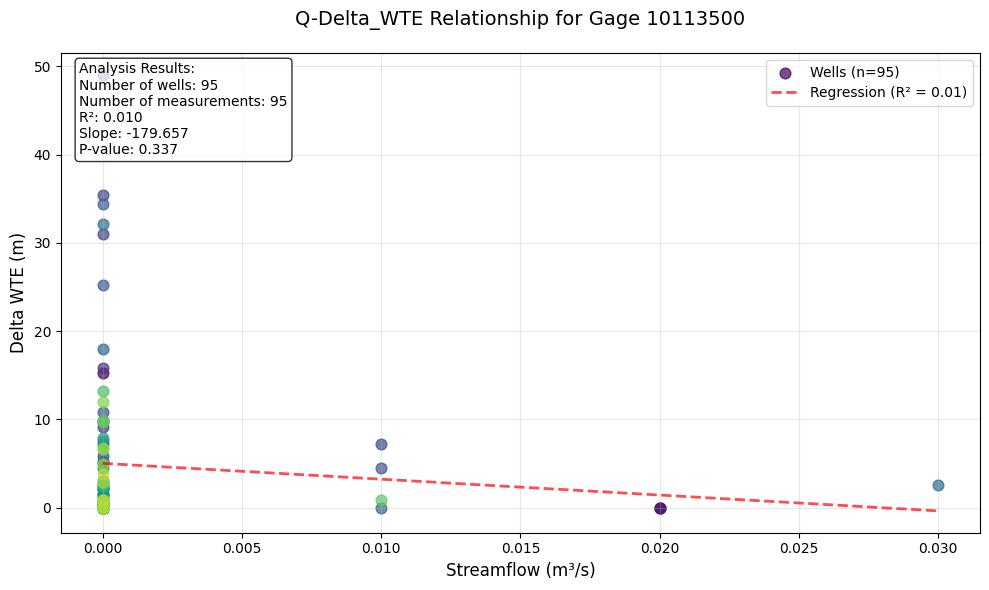


Processing gage 10143500


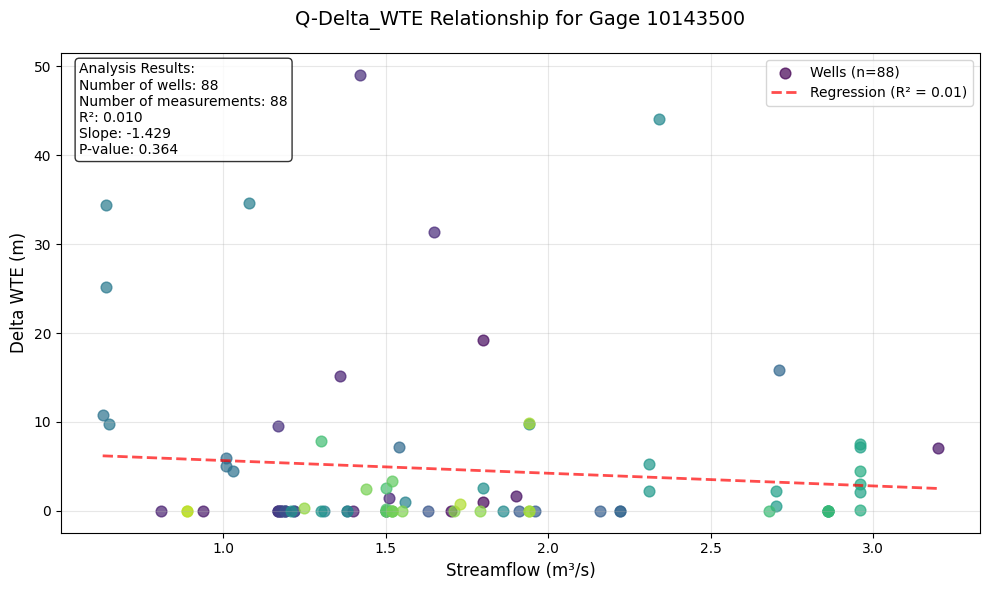


Processing gage 10131000


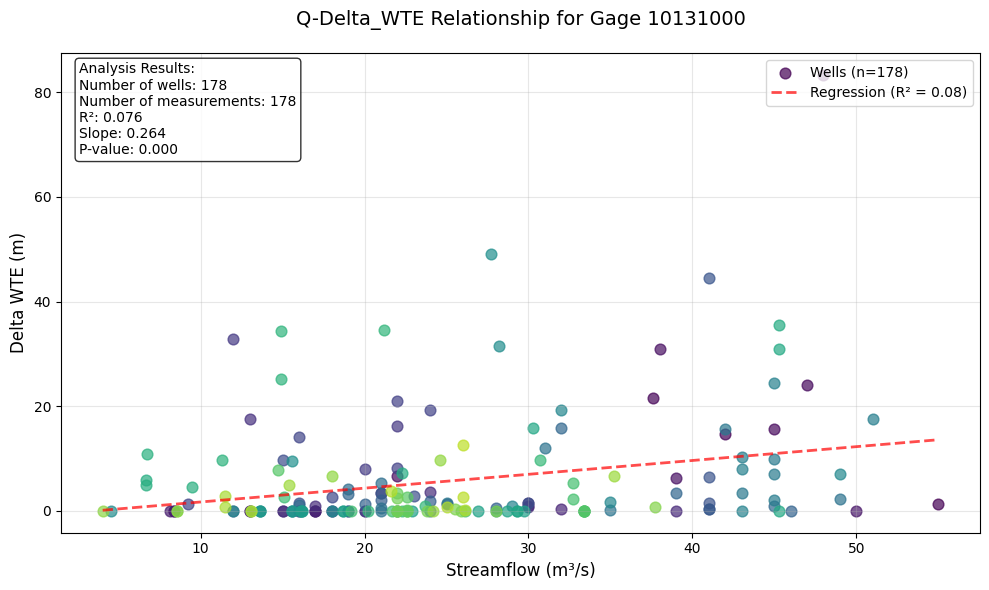


Processing gage 10038000


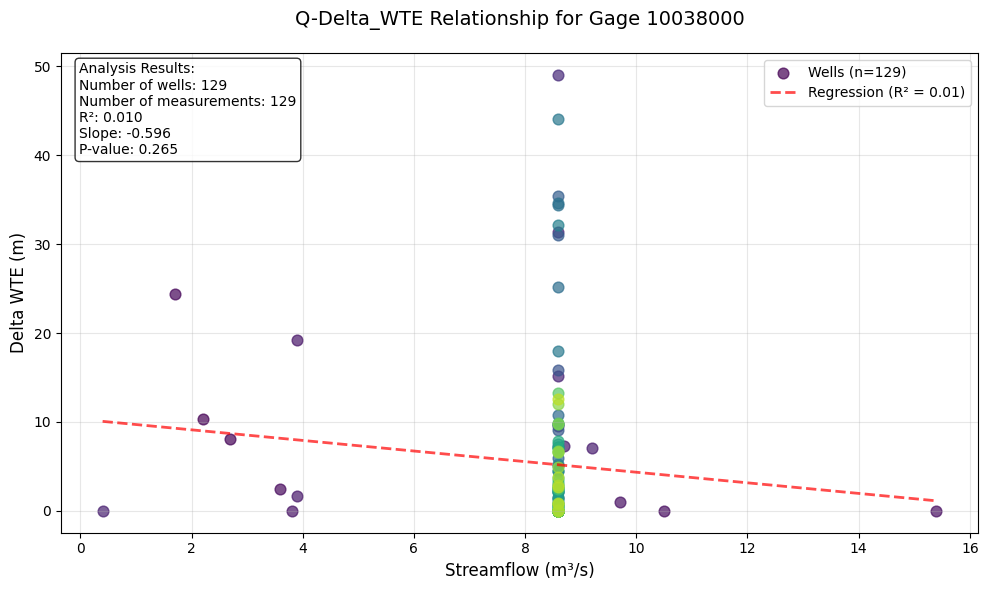


Processing gage 10141000


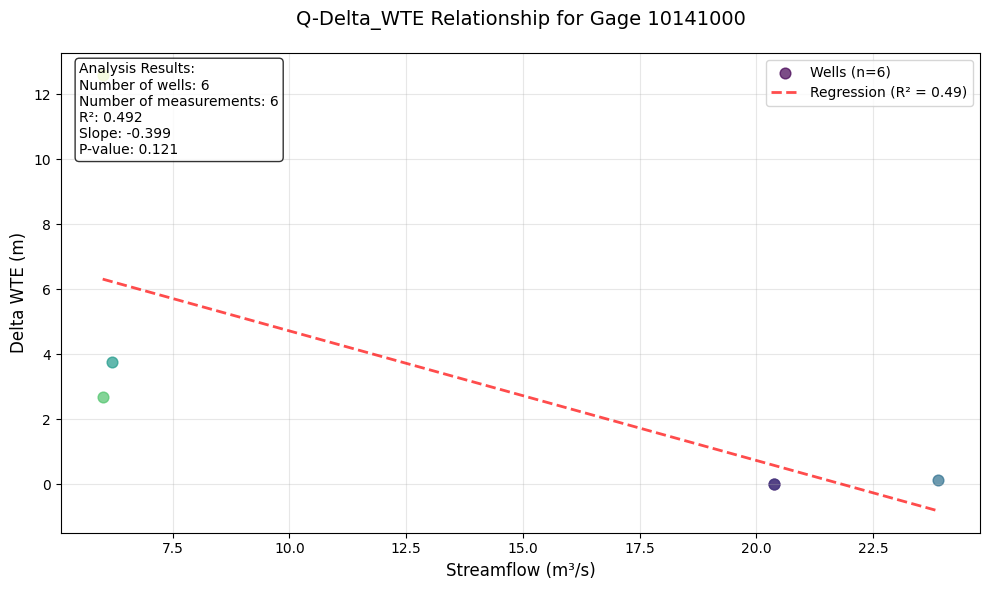


Processing gage 10152000


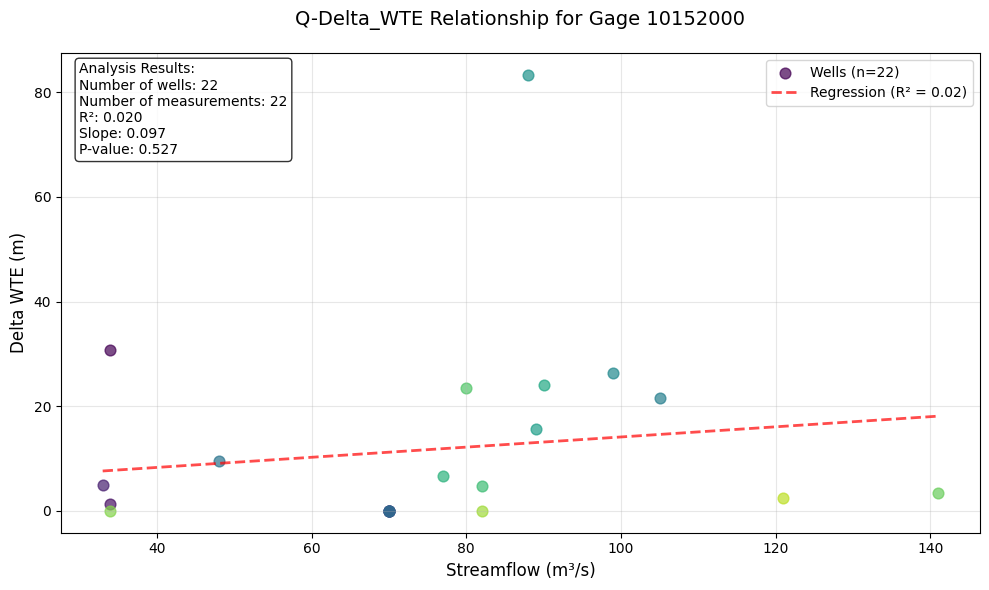


Processing gage 10015900


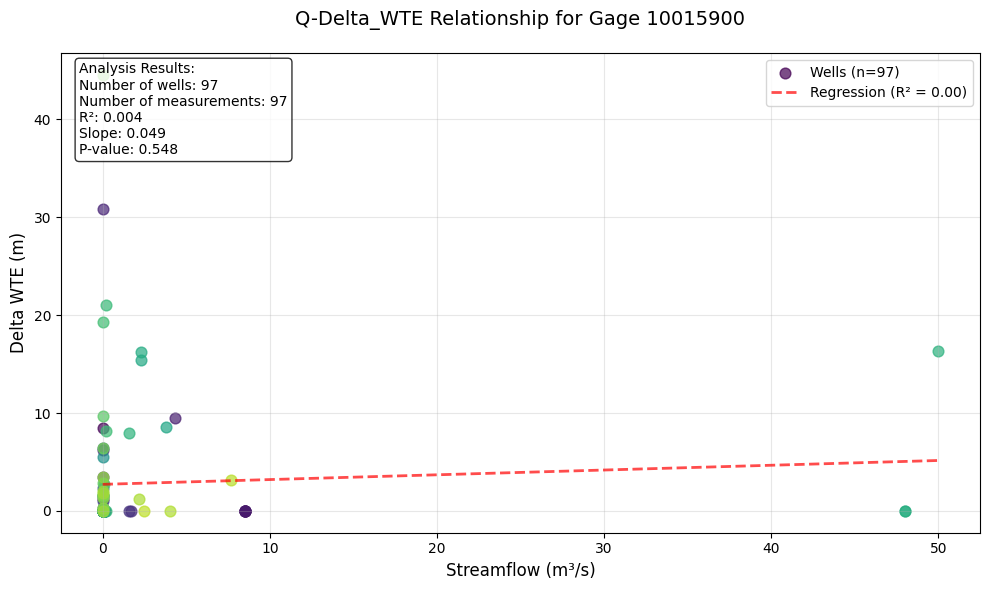


Processing gage 10134500


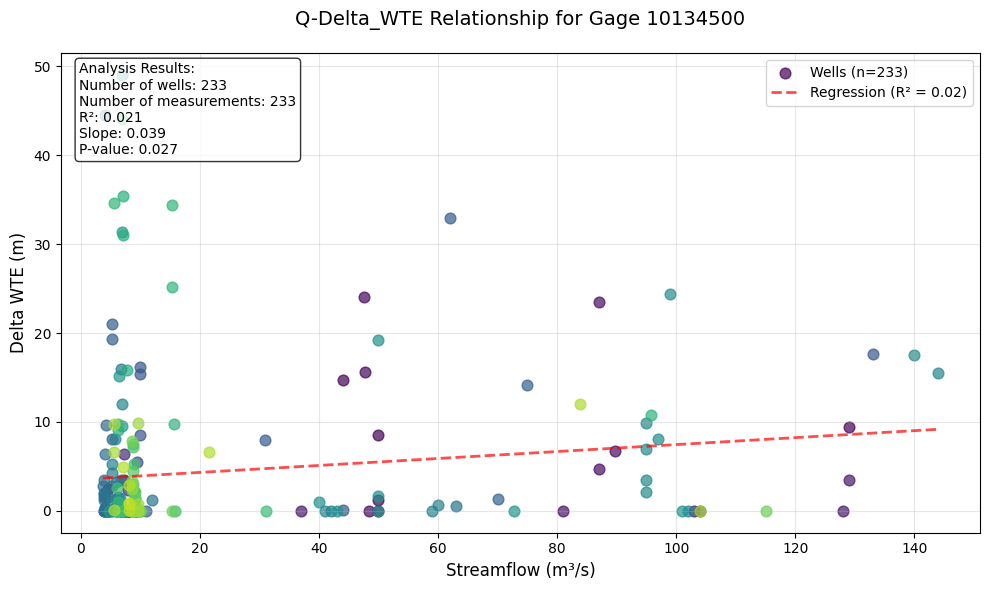


Processing gage 10150500


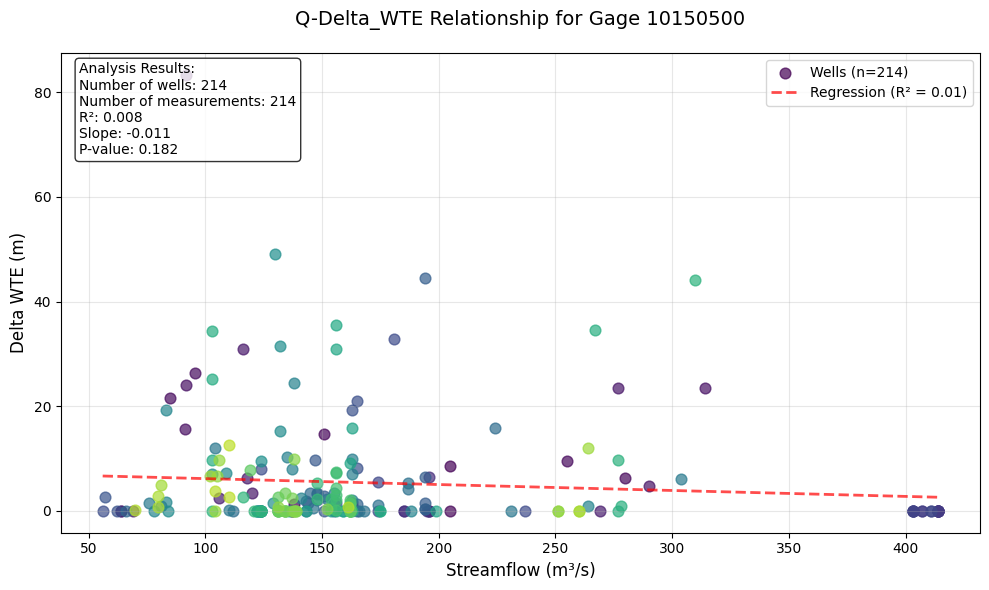


Processing gage 10106000


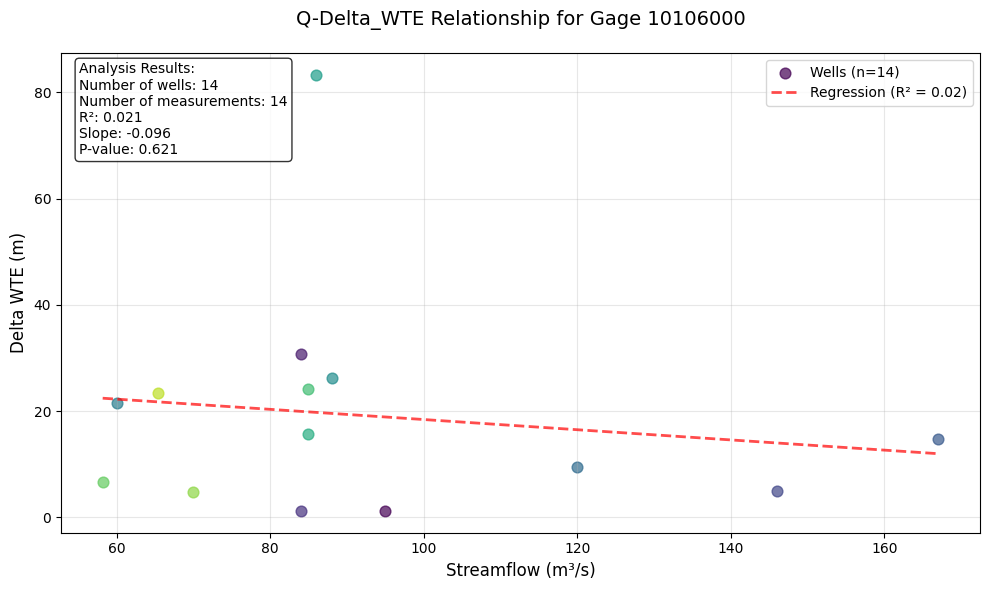


Processing gage 10126000


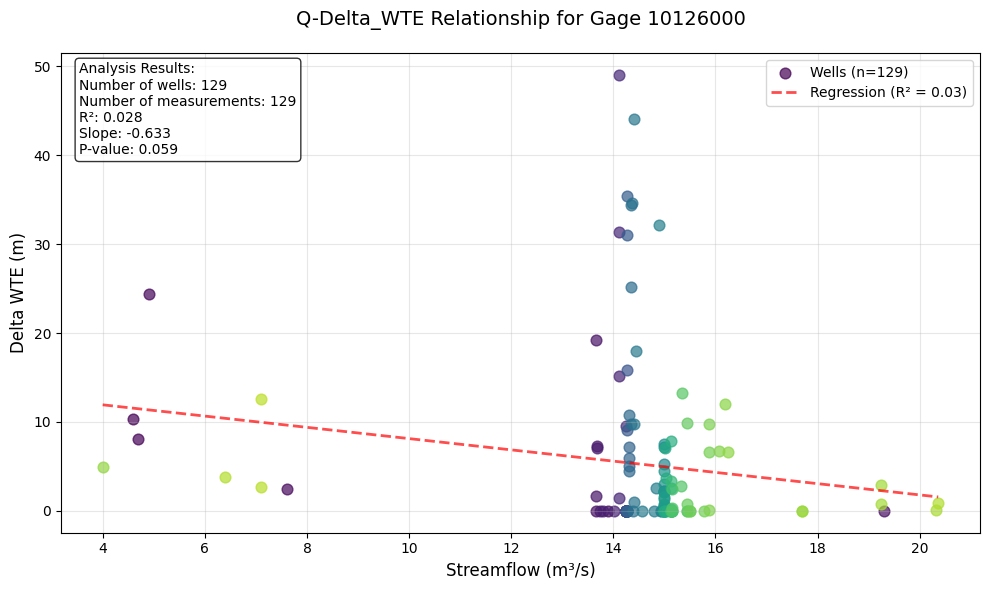


Processing gage 10129300


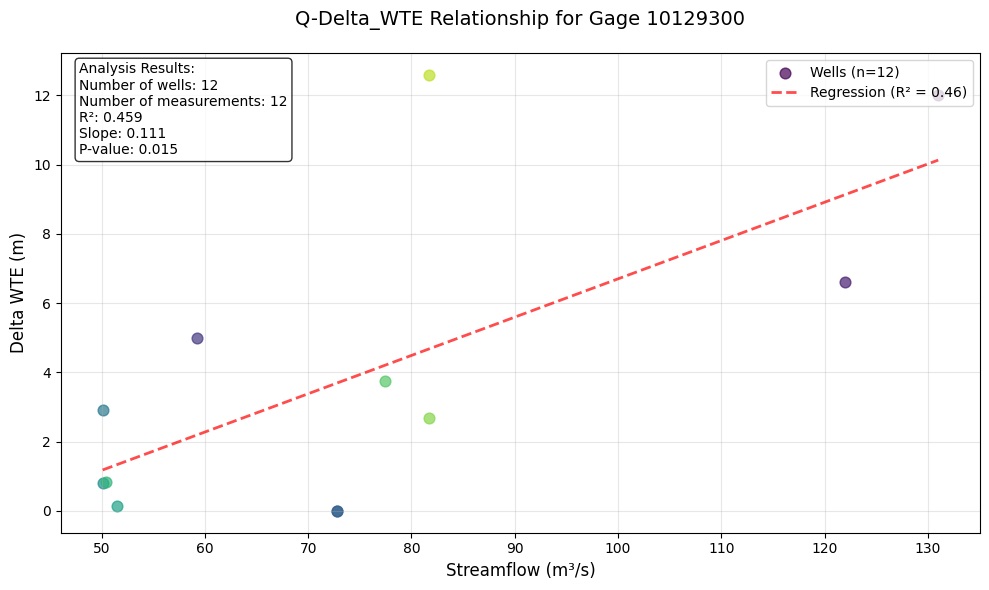


Overall Analysis Results:
Total gages analyzed: 66

R² statistics:
count    6.600000e+01
mean     4.533768e-02
std      1.066293e-01
min      5.243194e-07
25%      3.158458e-03
50%      1.419774e-02
75%      3.221991e-02
max      5.675202e-01
Name: overall_r2, dtype: float64


In [18]:
# Usage
stats_df = analyze_all_gages(input_dir='/content/paired_data')

In [19]:
def summarize_regression_results(stats_df):
    """
    Summarize regression statistics for all gages.

    Parameters:
    -----------
    stats_df : DataFrame
        DataFrame containing regression statistics for all gages

    Returns:
    --------
    dict: Summary statistics
    """
    # Basic counts
    total_gages = len(stats_df)
    total_wells = stats_df['n_wells'].sum()
    total_measurements = stats_df['n_measurements'].sum()

    # Regression direction
    positive_slopes = len(stats_df[stats_df['slope'] > 0])
    negative_slopes = len(stats_df[stats_df['slope'] < 0])

    # Significance levels
    significant_005 = len(stats_df[stats_df['p_value'] < 0.05])
    significant_001 = len(stats_df[stats_df['p_value'] < 0.01])

    # R² distribution
    r2_categories = pd.cut(stats_df['overall_r2'],
                          bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
                          labels=['0-0.1', '0.1-0.2', '0.2-0.3',
                                 '0.3-0.4', '0.4-0.5', '>0.5'])
    r2_distribution = r2_categories.value_counts().sort_index()

    # Create summary
    print("\nRegression Analysis Summary")
    print("=" * 50)
    print(f"Total gages analyzed: {total_gages}")
    print(f"Total wells: {total_wells}")
    print(f"Total measurements: {total_measurements}")
    print("\nSlope Direction:")
    print(f"Positive slopes: {positive_slopes} ({positive_slopes/total_gages*100:.1f}%)")
    print(f"Negative slopes: {negative_slopes} ({negative_slopes/total_gages*100:.1f}%)")
    print("\nStatistical Significance:")
    print(f"Significant at p<0.05: {significant_005} ({significant_005/total_gages*100:.1f}%)")
    print(f"Significant at p<0.01: {significant_001} ({significant_001/total_gages*100:.1f}%)")
    print("\nR² Distribution:")
    for category, count in r2_distribution.items():
        print(f"R² {category}: {count} ({count/total_gages*100:.1f}%)")

    # Additional statistics
    print("\nRegression Statistics:")
    print(f"Mean R²: {stats_df['overall_r2'].mean():.3f}")
    print(f"Median R²: {stats_df['overall_r2'].median():.3f}")
    print(f"Mean slope: {stats_df['slope'].mean():.3f}")
    print(f"Median slope: {stats_df['slope'].median():.3f}")

    return {
        'total_gages': total_gages,
        'total_wells': total_wells,
        'total_measurements': total_measurements,
        'positive_slopes': positive_slopes,
        'negative_slopes': negative_slopes,
        'significant_005': significant_005,
        'significant_001': significant_001,
        'r2_distribution': r2_distribution,
        'mean_r2': stats_df['overall_r2'].mean(),
        'median_r2': stats_df['overall_r2'].median(),
        'mean_slope': stats_df['slope'].mean(),
        'median_slope': stats_df['slope'].median()
    }

# Usage (after running analyze_all_gages):
# stats_df = analyze_all_gages(input_dir='/content/paired_data')
summary = summarize_regression_results(stats_df)


Regression Analysis Summary
Total gages analyzed: 66
Total wells: 8148
Total measurements: 8148

Slope Direction:
Positive slopes: 37 (56.1%)
Negative slopes: 29 (43.9%)

Statistical Significance:
Significant at p<0.05: 15 (22.7%)
Significant at p<0.01: 8 (12.1%)

R² Distribution:
R² 0-0.1: 61 (92.4%)
R² 0.1-0.2: 2 (3.0%)
R² 0.2-0.3: 0 (0.0%)
R² 0.3-0.4: 0 (0.0%)
R² 0.4-0.5: 2 (3.0%)
R² >0.5: 1 (1.5%)

Regression Statistics:
Mean R²: 0.045
Median R²: 0.014
Mean slope: -2.804
Median slope: 0.011
